# TinyTimeMixer (TTM) using dataset - Exchange Rate



In [ ]:
# Install the tsfm library
# ! pip install "granite-tsfm[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.22"

## Imports

In [2]:
import math
import os
import tempfile

import pandas as pd
import numpy as np
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
from transformers.integrations import INTEGRATION_TO_CALLBACK
import pickle

from tsfm_public import TimeSeriesPreprocessor, TrackingCallback, count_parameters, get_datasets, TinyTimeMixerForPrediction
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.lr_finder import optimal_lr_finder
from tsfm_public.toolkit.visualization import plot_predictions
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


In [3]:
import warnings


# Suppress all warnings
warnings.filterwarnings("ignore")

### Helper functions

In [4]:
# function for comparing the predicted values with actual values at a particular point in time (For ex: At 12/24/48 hrs from current time...)

def compare_forecast(forecast, date_col, prediction_col, actual_col, hours_out):
  comparisons = pd.DataFrame()
  comparisons[date_col] = forecast[date_col]
  actual = []
  pred = []

  for i in range(len(forecast)):
    pred.append(forecast[prediction_col].values[i][hours_out - 1]) # prediction for next day
    actual.append(forecast[actual_col].values[i][hours_out - 1])

  comparisons['actual'] = actual
  comparisons['pred'] = pred

  return comparisons

def construct_output_df(data, model_trainer):

    preds = model_trainer.predict(data)
    
    output_dict = {
        "date": [],
        "actual": [],
        "pred" : [],
        "context": [],
        "full_window": [],
    }      

    for i in range(len(data)):
        ts = data[i]["timestamp"]
        fv = data[i]["future_values"].numpy().flatten()
        pv = data[i]["past_values"].numpy().flatten()
        w = np.concatenate([pv, fv])

        output_dict["date"].append(ts)
        output_dict["actual"].append(list(fv))
        output_dict["context"].append(list(pv))
        output_dict["full_window"].append(list(w))

    # extracting zero shot predictions on val/test data
    for i in range(len(preds.predictions[0])):
        pred = preds.predictions[0][i].flatten()
        output_dict["pred"].append(list(pred))

    output_df = pd.DataFrame({
        "date": output_dict["date"],
        "prediction": output_dict["pred"],
        "actual": output_dict["actual"],
        "context": output_dict["context"],
        "full_window" : output_dict["full_window"],
    })
    return output_df


def plot_high_error_samples(rows, cols, df, error_threshold):

    indices = df.index[df["error"] > error_threshold].tolist()
    rand_indices = np.random.choice(indices, size=rows*cols, replace=False)

    fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
    axes = axes.flatten()

    for j, idx in enumerate(rand_indices):
        plot_df = pd.DataFrame({
            "pred": df.iloc[idx]['prediction'],
            "actual": df.iloc[idx]['actual']
        })
        axes[j].plot(plot_df)
        axes[j].set_title(f"Index {idx}")

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right")

    plt.tight_layout()
    plt.show()

def load_shapelet(base_path, dataset):

    file_path = os.path.join(base_path, f'{dataset}.pkl')
    with open(file_path, 'rb') as handle:
        a_dict = pickle.load(handle)
    
    return(pd.DataFrame(a_dict.values()).transpose())

def get_top_k_timestamps_per_cluster(df, k=3, ascending=False):
    results = {}
    results_list = []
    for cluster_id in df["cluster"].unique():
        subset = df[df["cluster"] == cluster_id]
        if ascending:
            top_k = subset.nsmallest(k, "distance")
        else:
            top_k = subset.nlargest(k, "distance")
        results[cluster_id] = top_k["timestamp"].tolist()
        results_list.extend(top_k["timestamp"].tolist())
    return results, results_list

def plot_shapelet_dict(shapelet_dict, cols):
    n_shapelets = len(shapelet_dict)
    rows = math.ceil(n_shapelets / cols)

    fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
    axs = axs.flatten()

    for i, (shapelet_id, shapelet) in enumerate(shapelet_dict.items()):
        axs[i].plot(shapelet, color='blue')
        axs[i].set_title(f"{shapelet_id}")
        axs[i].set_xlabel("Time")
        axs[i].set_ylabel("Value")

    plt.tight_layout()
    plt.show()



### Important arguments

In [7]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)


TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"
# TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r1"
# TTM_MODEL_PATH = "ibm-research/ttm-research-r2"

CONTEXT_LENGTH = 512
PREDICTION_LENGTH = 96
BATCH_SIZE = 64

TARGET_DATASET = "exchange_rate"
dataset_path = "/Users/shivanitomar/Documents/Implementations/SD_forger/FMforTS/data/monash_exchange_rate.csv"


# Results dir
OUT_DIR = "ttm_finetuned_models/"

timestamp_column = "timestamp"
id_columns = []  # mention the ids that uniquely identify a time-series.
target_columns = ['currency_4']

split_config = {
    "train": 0.7, 
    "test": 0.2
}

ex_rate_data = pd.read_csv(
    "/Users/shivanitomar/Documents/Implementations/SD_forger/FMforTS/data/monash_exchange_rate.csv",
    parse_dates=[timestamp_column],
)

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
    "observable_columns": []
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=CONTEXT_LENGTH,
    prediction_length=PREDICTION_LENGTH,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

dset_train, dset_val, dset_test = get_datasets(
        tsp,
        ex_rate_data,
        split_config,
        fewshot_fraction=1,
        fewshot_location="first",
        # use_frequency_token=fine_tuned_model.config.resolution_prefix_tuning,
    )
print("Length of train/val/test", len(dset_train), len(dset_val), len(dset_test))
print(len(ex_rate_data))



Length of train/val/test 4704 665 1422
7588


# Zero-shot performance on Validation and Test set

In [8]:
# Load model
zeroshot_model = get_model(
    TTM_MODEL_PATH,
    context_length=CONTEXT_LENGTH,
    prediction_length=PREDICTION_LENGTH,
    freq_prefix_tuning=False,
    freq=None,
    prefer_l1_loss=False,
    prefer_longer_context=True,
    # adding TTM model config
    prediction_channel_indices=tsp.prediction_channel_indices,
    num_input_channels=tsp.num_input_channels,
)
temp_dir = tempfile.mkdtemp()

# zeroshot_trainer
zeroshot_trainer = Trainer(
    model=zeroshot_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=BATCH_SIZE,
        seed=SEED,
        report_to="none",
    ),
)
# evaluate zero-shot performance
print("+" * 20, "Val MSE zero-shot", "+" * 20)
zeroshot_val_output = zeroshot_trainer.evaluate(dset_val)
print("zeroshot performance on validation set", zeroshot_val_output)



INFO:p-76185:t-8466403200:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-76185:t-8466403200:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-76185:t-8466403200:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


++++++++++++++++++++ Val MSE zero-shot ++++++++++++++++++++


zeroshot performance on validation set {'eval_loss': 0.4505707025527954, 'eval_model_preparation_time': 0.0016, 'eval_runtime': 0.2968, 'eval_samples_per_second': 2240.846, 'eval_steps_per_second': 37.067}


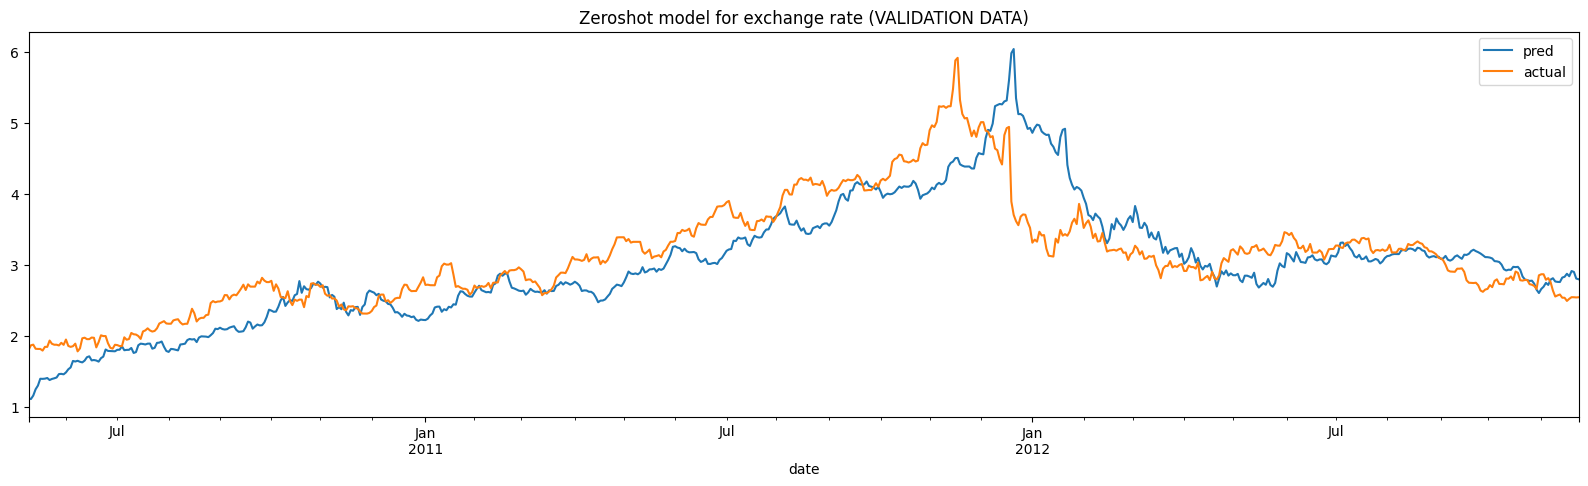

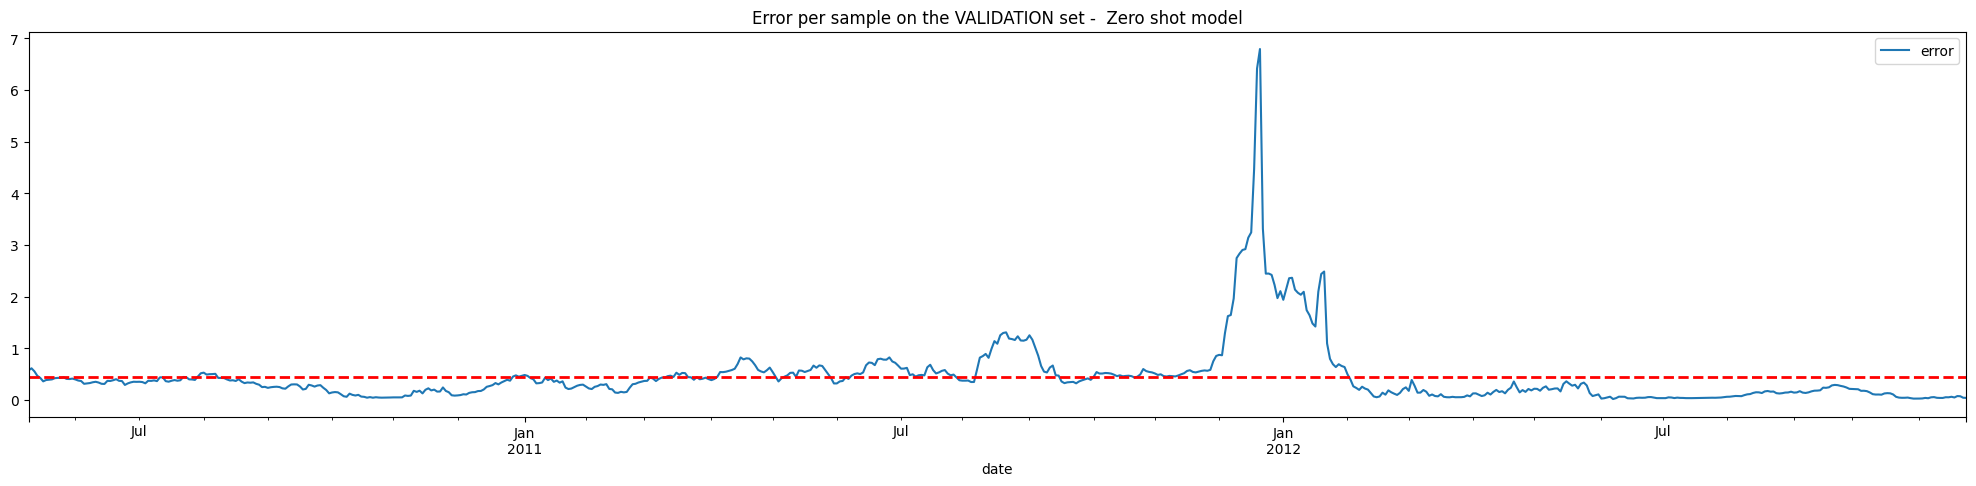

In [95]:
zs_val_df = construct_output_df(dset_val, zeroshot_trainer)

zs_val_predictions = compare_forecast(zs_val_df, "date", "prediction", "actual", 24)
zs_val_predictions.plot(x="date", y=["pred", "actual"], figsize=(20,5), title="Zeroshot model for exchange rate (VALIDATION DATA)")

zs_val_df["error"] = zs_val_df.apply(lambda row: mean_squared_error([row["prediction"]], [row["actual"]]), axis=1)
ax = zs_val_df.plot(x="date", y=["error"], figsize=(25, 5), title="Error per sample on the VALIDATION set -  Zero shot model")
ax.axhline(y=zs_val_df['error'].mean(), color="red", linestyle="--", linewidth=2, label=f"Avg Error = {zs_val_df['error'].mean():.3f}")

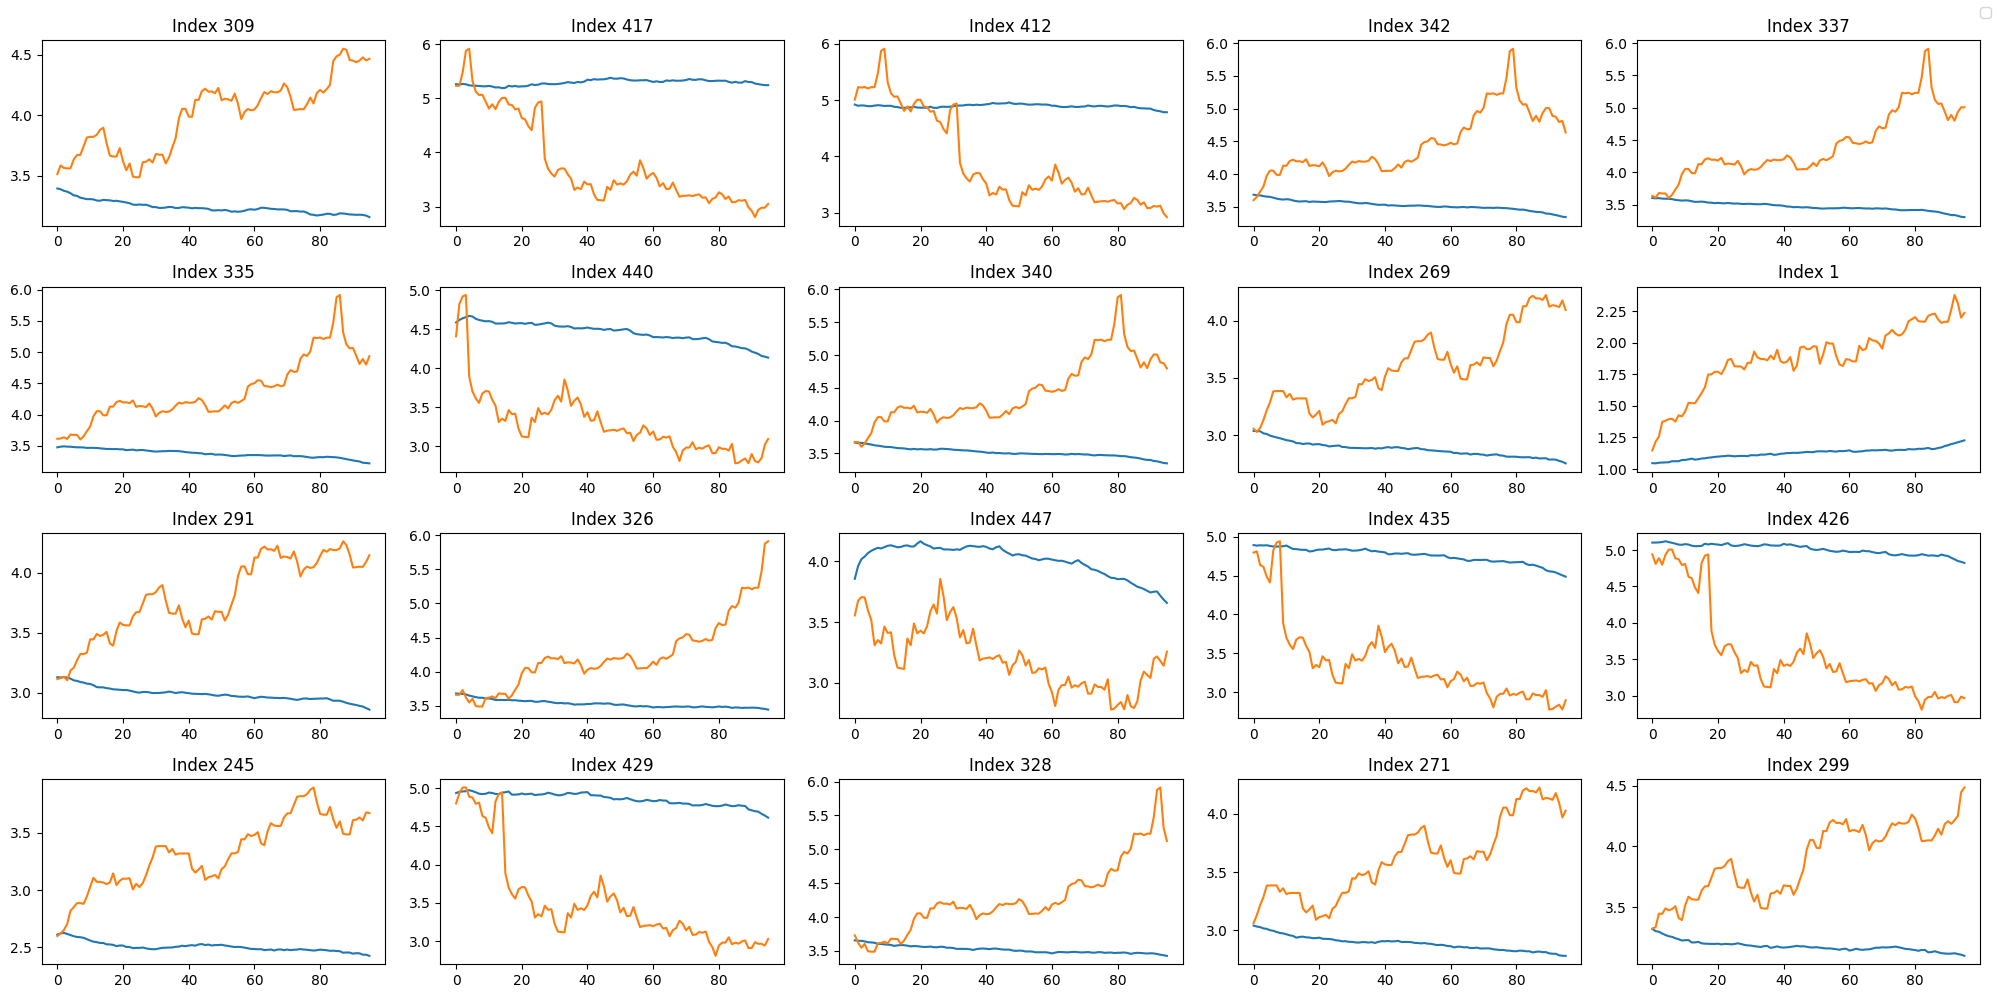

In [96]:
plot_high_error_samples(4, 5, zs_val_df, error_threshold=0.6)

In [97]:
print("+" * 20, "Test MSE zero-shot", "+" * 20)
zeroshot_test_output = zeroshot_trainer.evaluate(dset_test)
print("zeroshot performance on test set", zeroshot_test_output)

++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


zeroshot performance on test set {'eval_loss': 0.07903576642274857, 'eval_model_preparation_time': 0.0012, 'eval_runtime': 0.4016, 'eval_samples_per_second': 3540.705, 'eval_steps_per_second': 57.269}


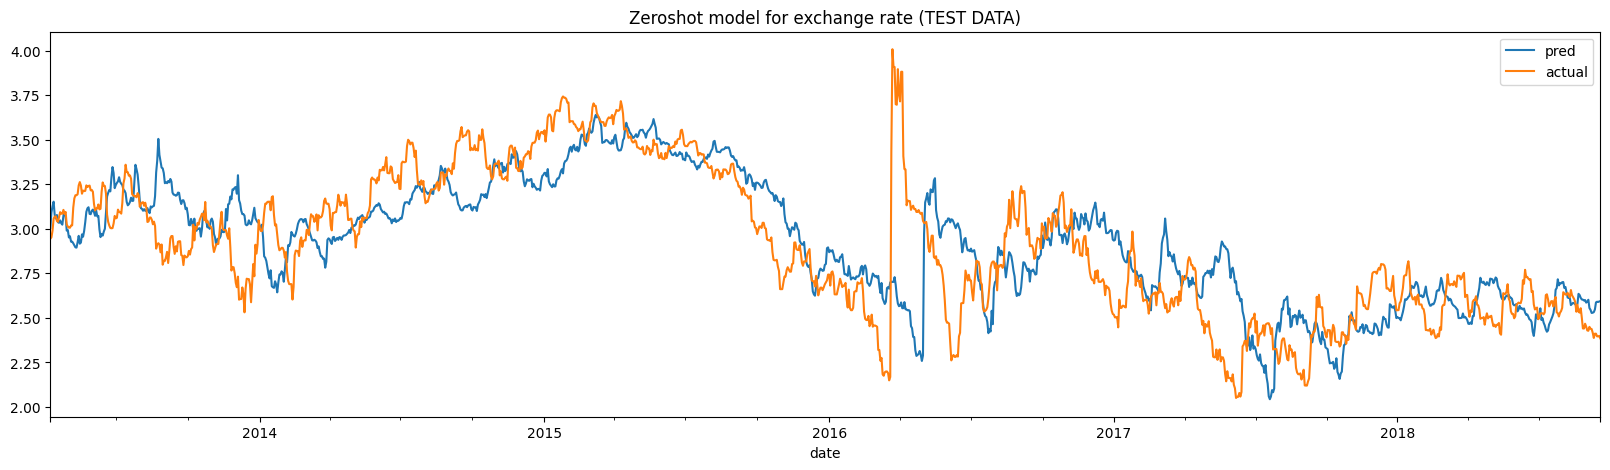

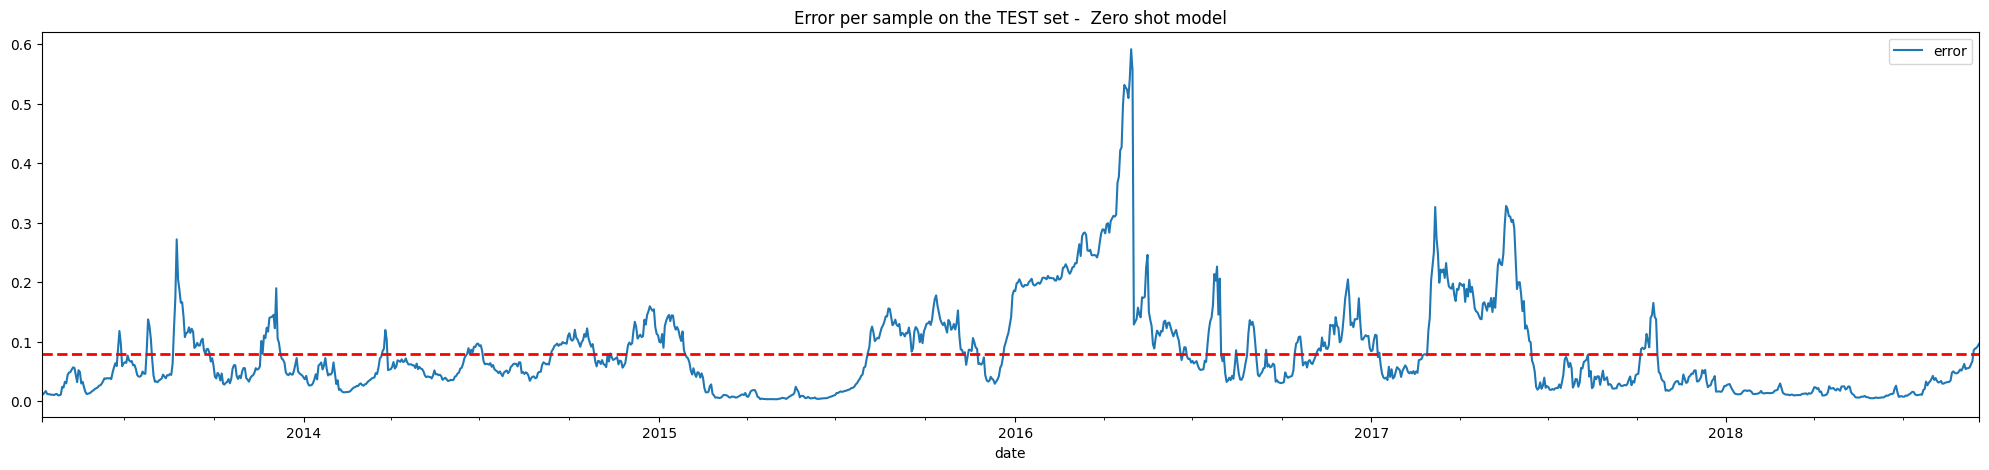

In [98]:
zs_test_df = construct_output_df(dset_test, zeroshot_trainer)

zs_test_predictions = compare_forecast(zs_test_df, "date", "prediction", "actual", 30)
zs_test_predictions.plot(x="date", y=["pred", "actual"], figsize=(20,5), title="Zeroshot model for exchange rate (TEST DATA)")

zs_test_df["error"] = zs_test_df.apply(lambda row: mean_squared_error([row["prediction"]], [row["actual"]]), axis=1)
ax2 = zs_test_df.plot(x="date", y=["error"], figsize=(25, 5), title="Error per sample on the TEST set -  Zero shot model")
ax2.axhline(y=zs_test_df['error'].mean(), color="red", linestyle="--", linewidth=2, label=f"Avg Error = {zs_test_df['error'].mean():.3f}")

### Samples where the error threshold (>0.6)

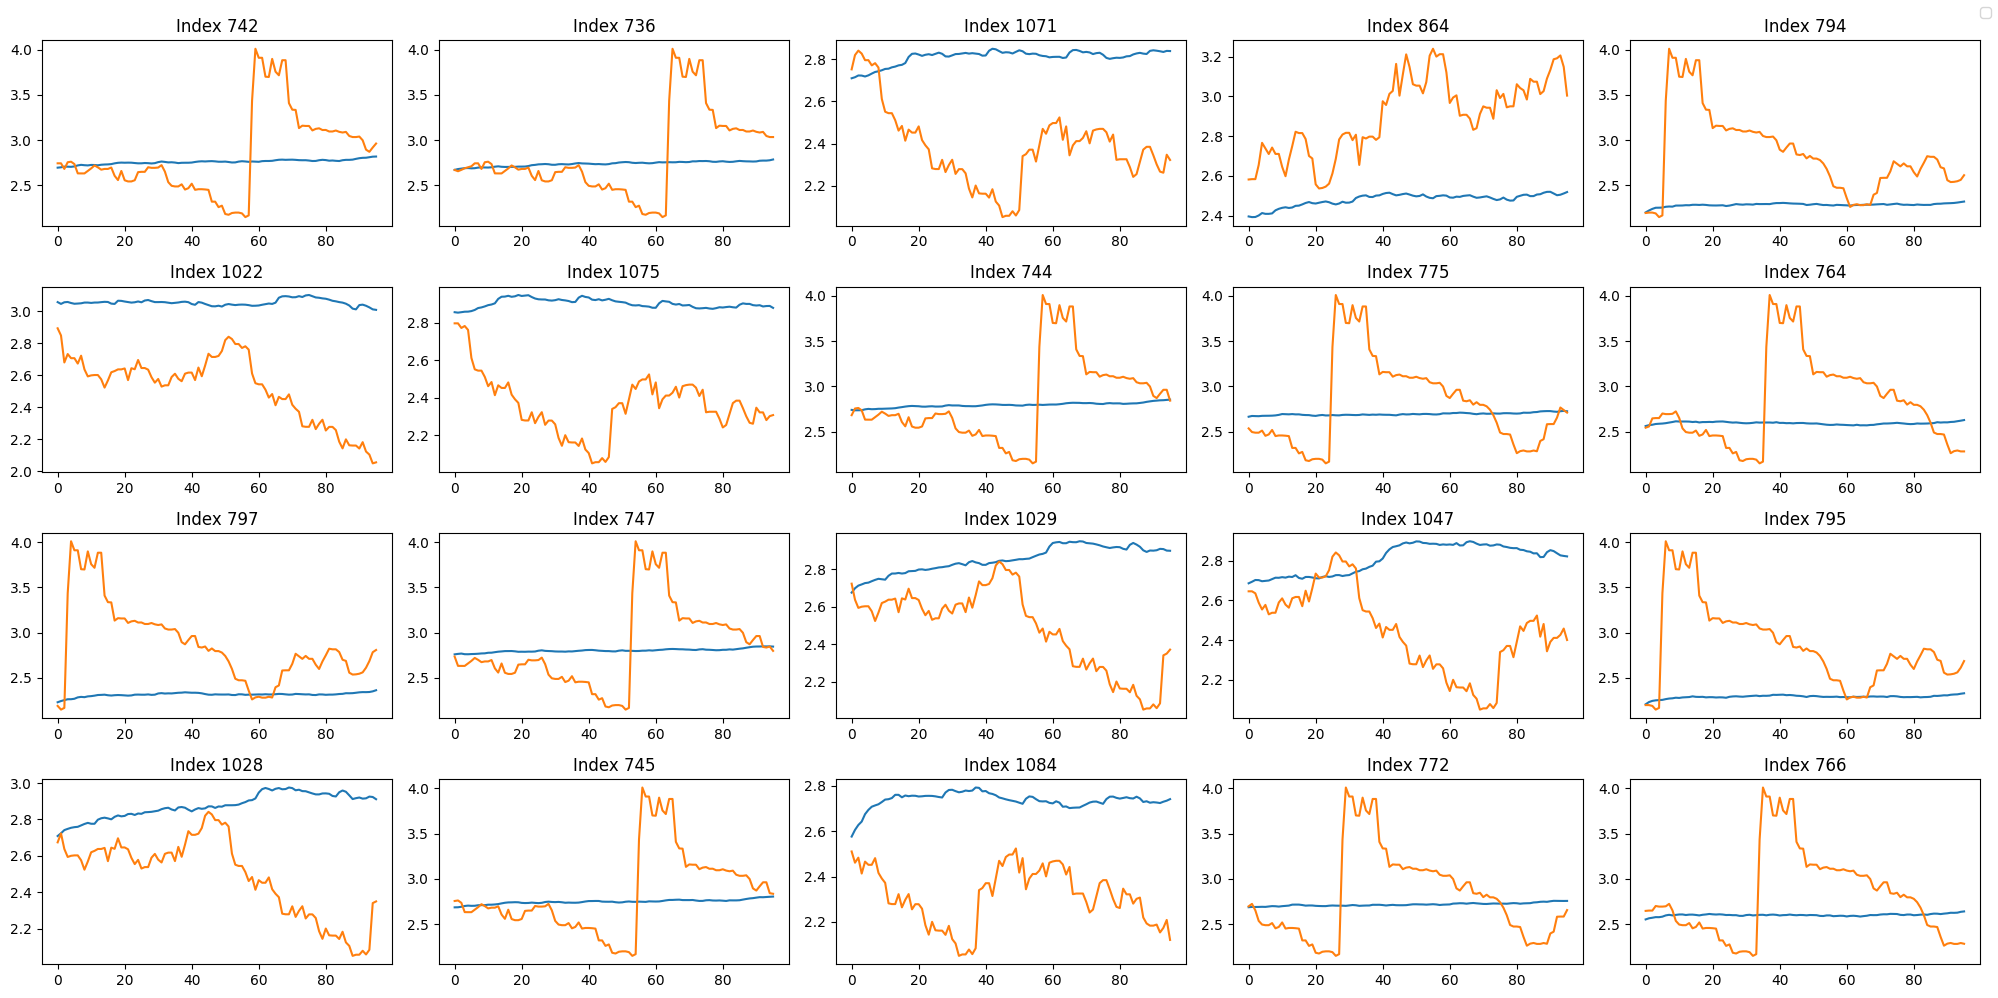

In [99]:
plot_high_error_samples(4, 5, zs_test_df, error_threshold=0.2)

### Shapelets learned for exchange rate

In [ ]:
dataset1 = "exchange_rate"
base_path = '/Users/shivanitomar/Documents/Implementations/autotune_extension/learned_shapelets'

df_target1 = load_shapelet(base_path, dataset1)
df_shapelets = df_target1.transpose()

for i in range(len(df_shapelets)):
    plt.figure()
    plt.plot(df_shapelets.loc[i])
    plt.show()

# Fine-tuned performance on Validation and Test set

In [108]:
# targeted training of model 

def fft_finetune_eval(
    dataset_name,
    batch_size,
    learning_rate=None,
    context_length=512,
    forecast_length=96,
    fewshot_percent=100,
    freeze_backbone=True,
    num_epochs=10,
    save_dir=OUT_DIR,
    loss="mse",
    quantile=0.5,
):
    out_dir = os.path.join(save_dir, dataset_name)

    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)

    # Data prep: Get dataset
    

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )
    print("+" * 20, "TSP values", "+" * 20)
    print(tsp.prediction_channel_indices)
    print(tsp.exogenous_channel_indices)
    print(tsp.context_length)
    print(tsp.prediction_length)
    print(tsp.num_input_channels)
    print(tsp.scaler_type)




    # change head dropout to 0.7 for ett datasets
    if "ett" in dataset_name:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            prediction_channel_indices=tsp.prediction_channel_indices,
            num_input_channels=tsp.num_input_channels,

            head_dropout=0.4,
            loss=loss,
            quantile=quantile,
        )
    else:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            head_dropout=0.4,
            # Can also provide TTM Config args
            loss=loss,
            quantile=quantile,
        )

    dset_train, dset_val, dset_test = get_datasets(
        tsp,
        ex_rate_data,
        split_config,
        fewshot_fraction=fewshot_percent / 100,
        fewshot_location="first",
        use_frequency_token=finetune_forecast_model.config.resolution_prefix_tuning,
        
    )
    print("after get_datasets ------", len(dset_train))

    if freeze_backbone:
        print(
            "Number of params before freezing backbone",
            count_parameters(finetune_forecast_model),
        )

        # Freeze the backbone of the model
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False

        # Count params
        print(
            "Number of params after freezing the backbone",
            count_parameters(finetune_forecast_model),
        )

    # Find optimal learning rate
    # Use with caution: Set it manually if the suggested learning rate is not suitable
    if learning_rate is None:
        learning_rate, finetune_forecast_model = optimal_lr_finder(
            finetune_forecast_model,
            dset_train,
            batch_size=batch_size,
        )
        print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(out_dir, "v3_output_currency4"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        eval_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to="none",
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(out_dir, "logs"),  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
        seed=SEED,
    )

    # Create the early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=5,  # Number of epochs with no improvement after which to stop
        early_stopping_threshold=1e-5,  # Minimum improvement required to consider as improvement
    )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train) / (batch_size)),
    )
    print("length of training set is", len(dset_train))
    
    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )
    finetune_forecast_trainer.remove_callback(INTEGRATION_TO_CALLBACK["codecarbon"])

    # Fine tune
    finetune_forecast_trainer.train()

    # Evaluation
    print("+" * 20, f"Test MSE after few-shot {fewshot_percent}% fine-tuning", "+" * 20)

    finetune_forecast_trainer.model.loss = "mse"  # fixing metric to mse for evaluation

    fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
    print(fewshot_output)
    print("+" * 60)

    # get predictions

    predictions_dict = finetune_forecast_trainer.predict(dset_test)
    print("prediction metrics on test set", predictions_dict[2])

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    # plot
    plot_predictions(
        model=  finetune_forecast_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_fewshot",
        indices=[685, 118, 902],
        channel=0,
    )
    return predictions_dict

INFO:p-36595:t-8466403200:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 100% --------------------
++++++++++++++++++++ TSP values ++++++++++++++++++++
[0]
[]
512
96
1
standard


INFO:p-36595:t-8466403200:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-36595:t-8466403200:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


after get_datasets ------ 4704
Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.001
length of training set is 4704


[TrackingCallback] Mean Epoch Time = 60.38567778799269 seconds, Total Train Time = 1068.9365100860596
++++++++++++++++++++ Test MSE after few-shot 100% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.08027415722608566, 'eval_runtime': 58.2275, 'eval_samples_per_second': 24.421, 'eval_steps_per_second': 0.395, 'epoch': 9.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
prediction metrics on test set {'test_loss': 0.08027415722608566, 'test_runtime': 58.6286, 'test_samples_per_second': 24.254, 'test_steps_per_second': 0.392}
(1422, 96, 1)
(1422, 1, 8, 192)


PredictionOutput(predictions=(array([[[3.034611 ],
        [3.0970695],
        [3.0881   ],
        ...,
        [3.19163  ],
        [3.207618 ],
        [3.211282 ]],

       [[3.114546 ],
        [3.1692178],
        [3.1545966],
        ...,
        [3.2707617],
        [3.2965755],
        [3.303961 ]],

       [[3.1430655],
        [3.1888716],
        [3.179182 ],
        ...,
        [3.2765071],
        [3.3065102],
        [3.316345 ]],

       ...,

       [[2.6227822],
        [2.6243105],
        [2.619609 ],
        ...,
        [2.4960065],
        [2.4975114],
        [2.4963546]],

       [[2.6251009],
        [2.6289918],
        [2.6185396],
        ...,
        [2.4843032],
        [2.4879057],
        [2.4852927]],

       [[2.639585 ],
        [2.6369243],
        [2.6303406],
        ...,
        [2.5383286],
        [2.5398571],
        [2.5366201]]], dtype=float32), array([[[[-0.01767771, -0.12785909,  0.07375844, ...,  0.03067425,
          -0.05611922, -0.21

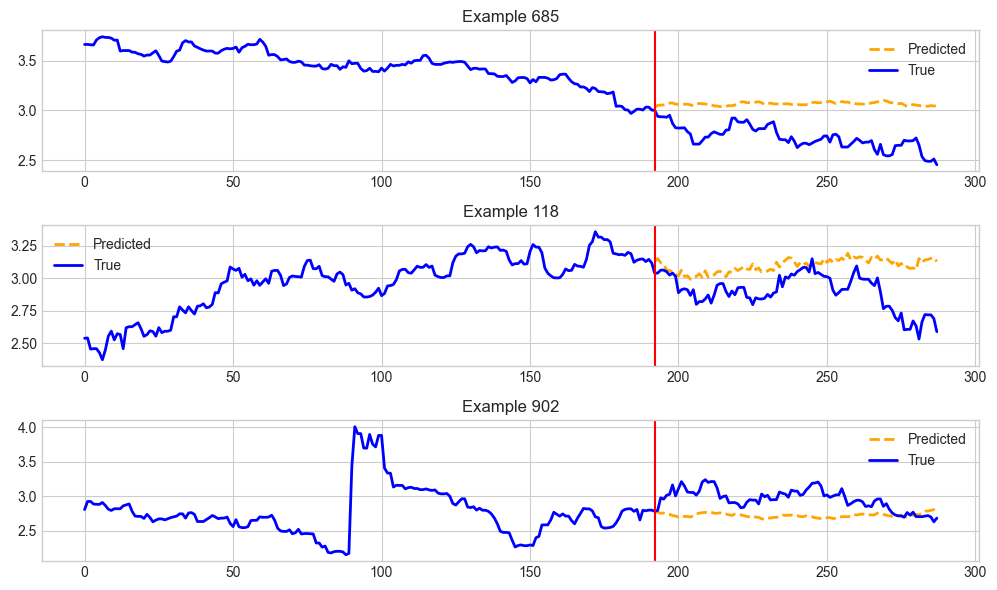

In [109]:
fft_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=100,
    learning_rate=0.001,
    num_epochs=20,
)

In [110]:
# loading the fine-tuned TTM model

fft_model = TinyTimeMixerForPrediction.from_pretrained("/Users/shivanitomar/Documents/Implementations/granite-tsfm/notebooks/hfdemo/ttm_finetuned_models/exchange_rate/v3_output_currency4/checkpoint-296")
temp_dir = tempfile.mkdtemp()

finetuned_trainer = Trainer(
        model=fft_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=64,
            seed=SEED,
            report_to="none",
        ),
    )

print("+" * 20, "Val MSE fine-tuned", "+" * 20)
finetuned_val_output = finetuned_trainer.evaluate(dset_val)
print("finetuned performance on validation set", finetuned_val_output)


++++++++++++++++++++ Val MSE fine-tuned ++++++++++++++++++++


finetuned performance on validation set {'eval_loss': 0.4041496217250824, 'eval_model_preparation_time': 0.0011, 'eval_runtime': 0.2113, 'eval_samples_per_second': 3146.742, 'eval_steps_per_second': 52.051}


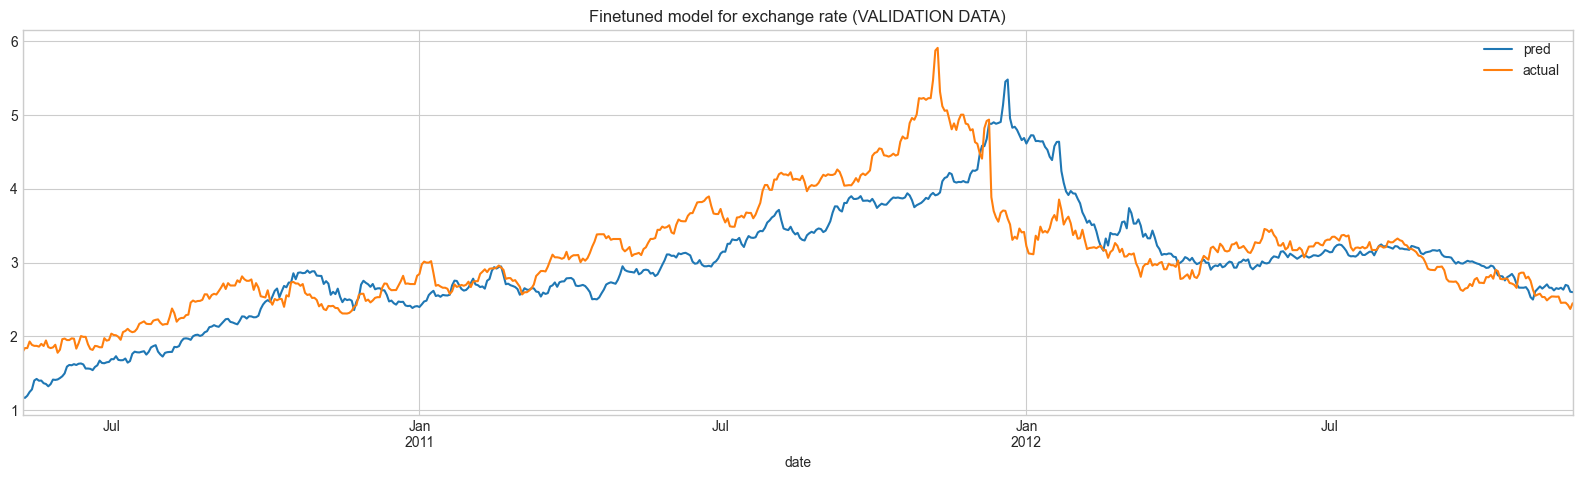

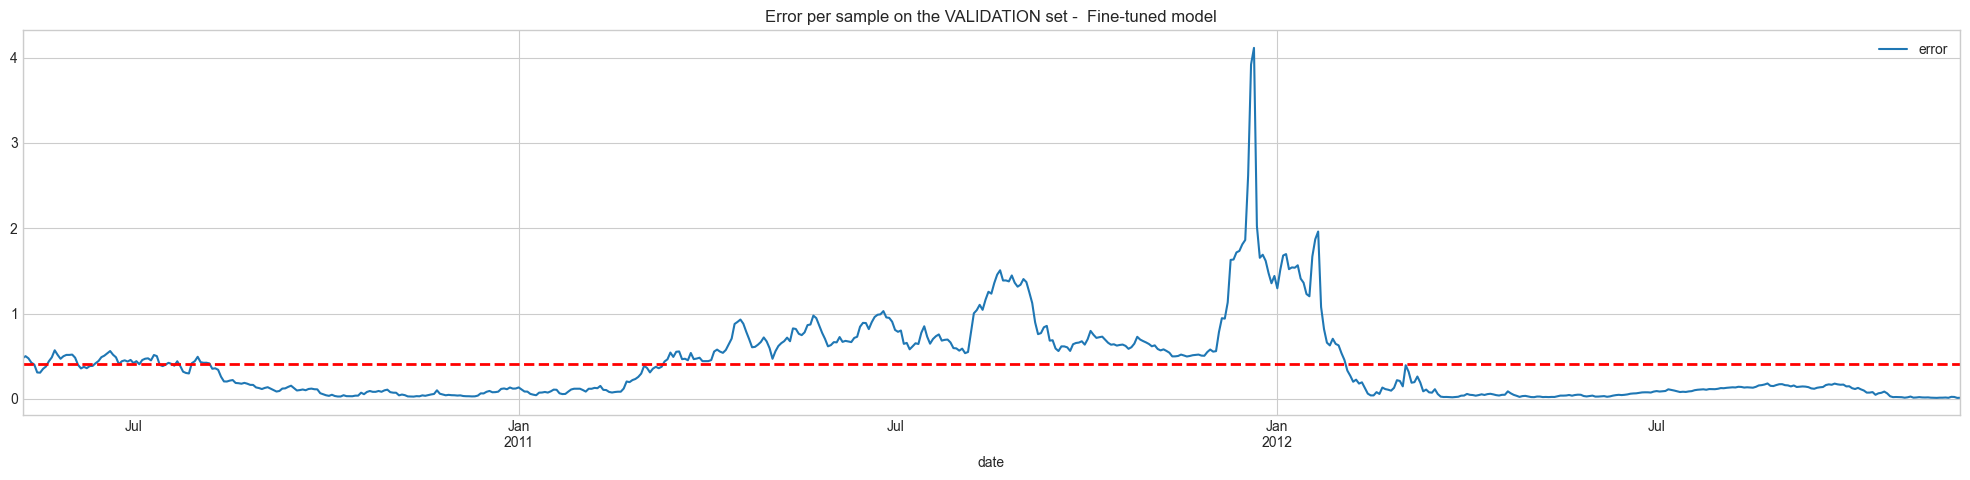

In [111]:
ft_val_df = construct_output_df(dset_val, finetuned_trainer)

ft_val_predictions = compare_forecast(ft_val_df, "date", "prediction", "actual", 30)
ft_val_predictions.plot(x="date", y=["pred", "actual"], figsize=(20,5), title="Finetuned model for exchange rate (VALIDATION DATA)")

ft_val_df["error"] = ft_val_df.apply(lambda row: mean_squared_error([row["prediction"]], [row["actual"]]), axis=1)
ax = ft_val_df.plot(x="date", y=["error"], figsize=(25, 5), title="Error per sample on the VALIDATION set -  Fine-tuned model")
ax.axhline(y=ft_val_df['error'].mean(), color="red", linestyle="--", linewidth=2, label=f"Avg Error = {ft_val_df['error'].mean():.3f}")

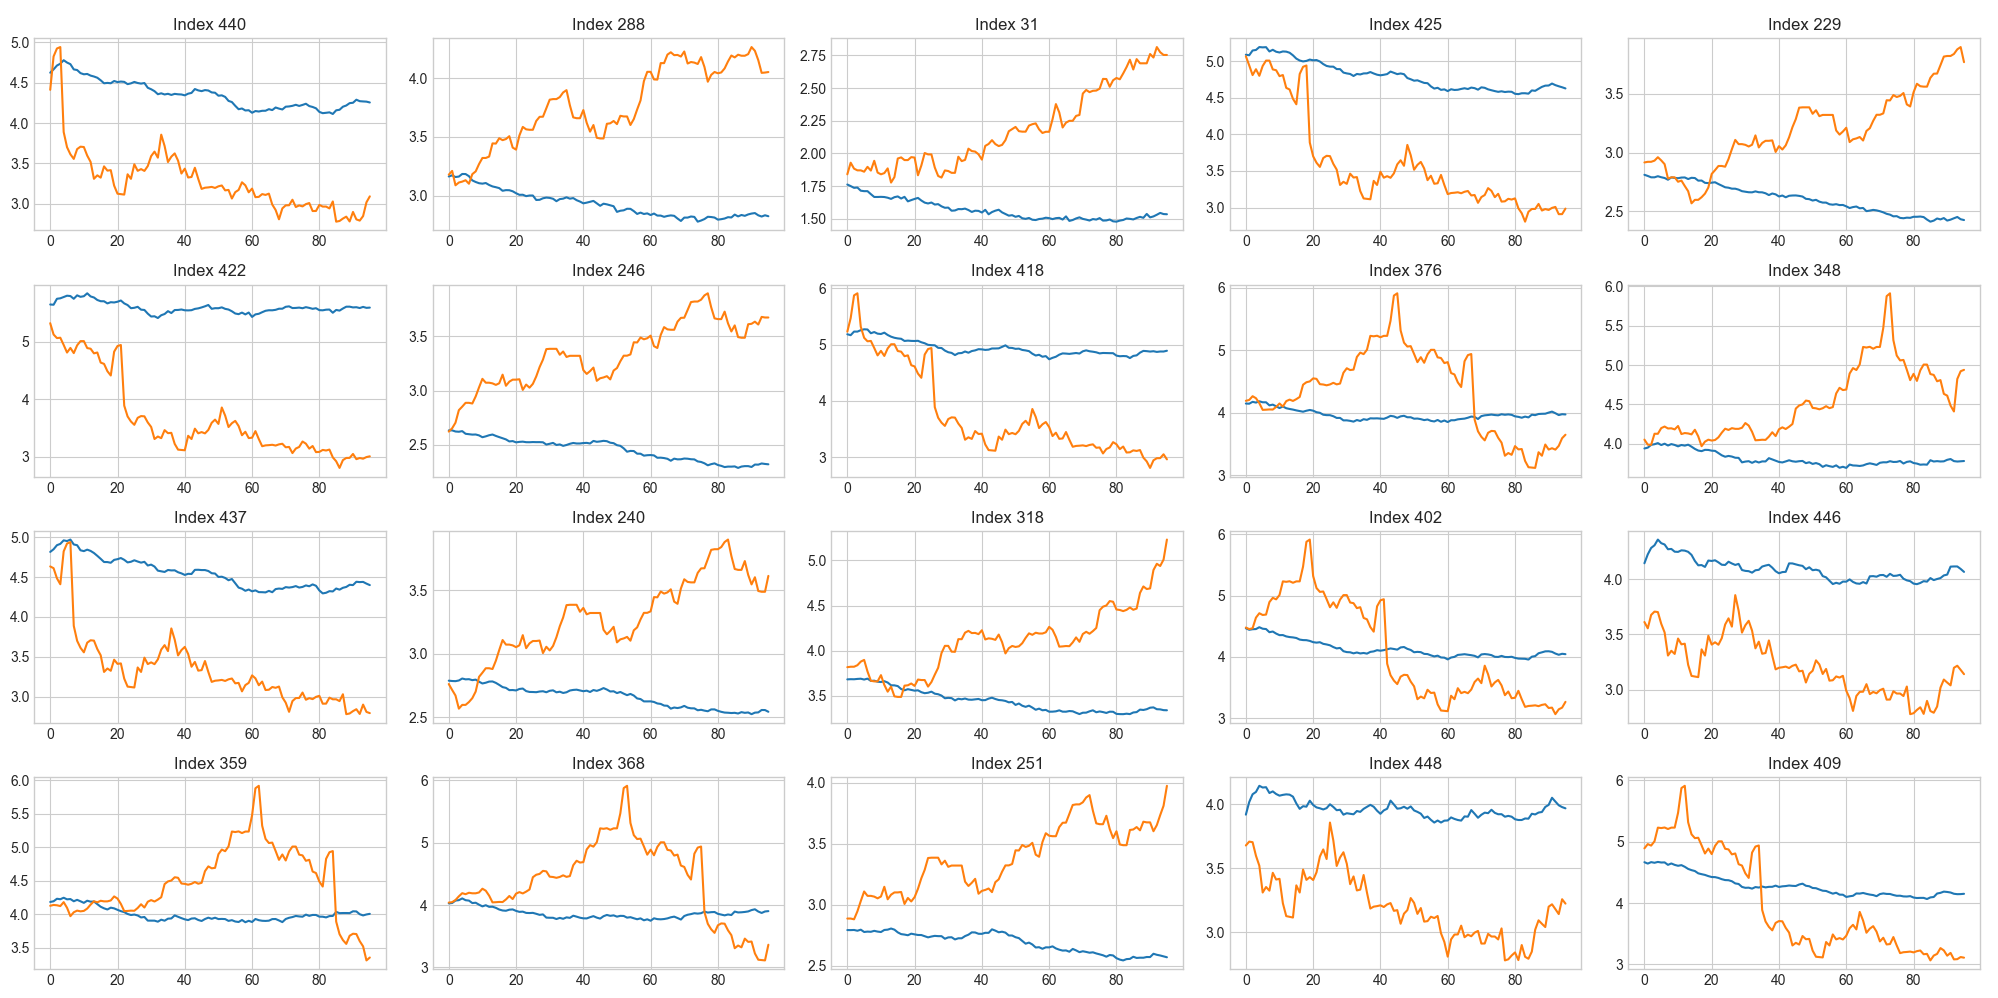

In [112]:
plot_high_error_samples(4, 5, ft_val_df, error_threshold=0.5)

In [114]:
print("+" * 20, "Test MSE fine-tuned", "+" * 20)
finetuned_test_output = finetuned_trainer.evaluate(dset_test)
print("finetuned performance on test set", finetuned_test_output)

++++++++++++++++++++ Test MSE fine-tuned ++++++++++++++++++++
finetuned performance on test set {'eval_loss': 0.08027415722608566, 'eval_model_preparation_time': 0.0011, 'eval_runtime': 0.3963, 'eval_samples_per_second': 3588.473, 'eval_steps_per_second': 58.041}


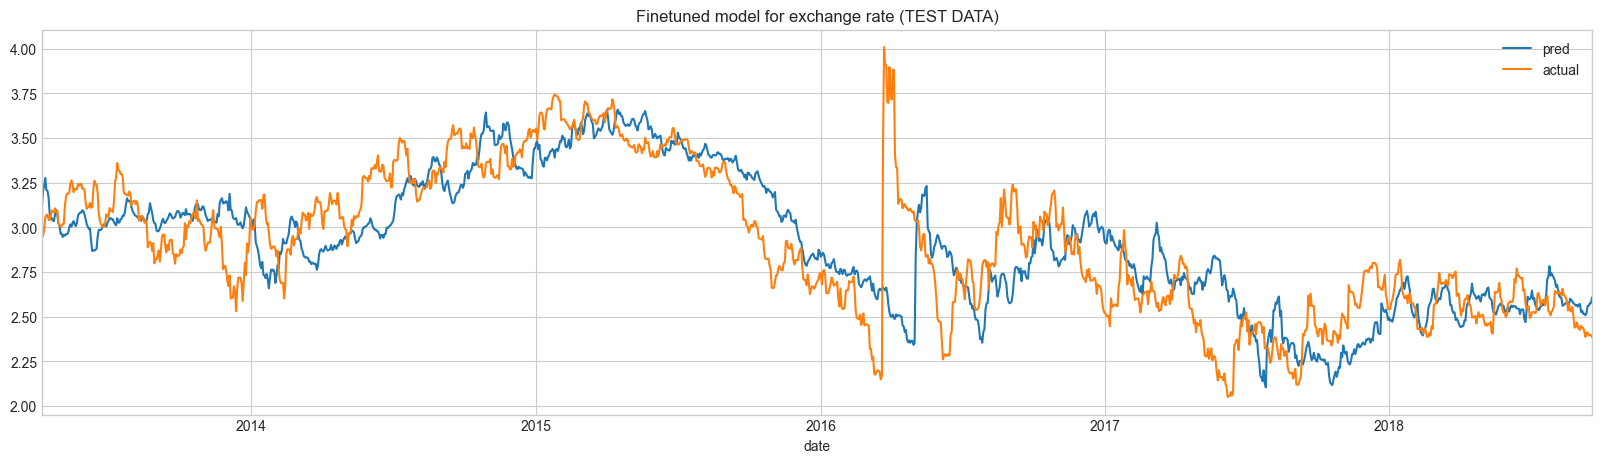

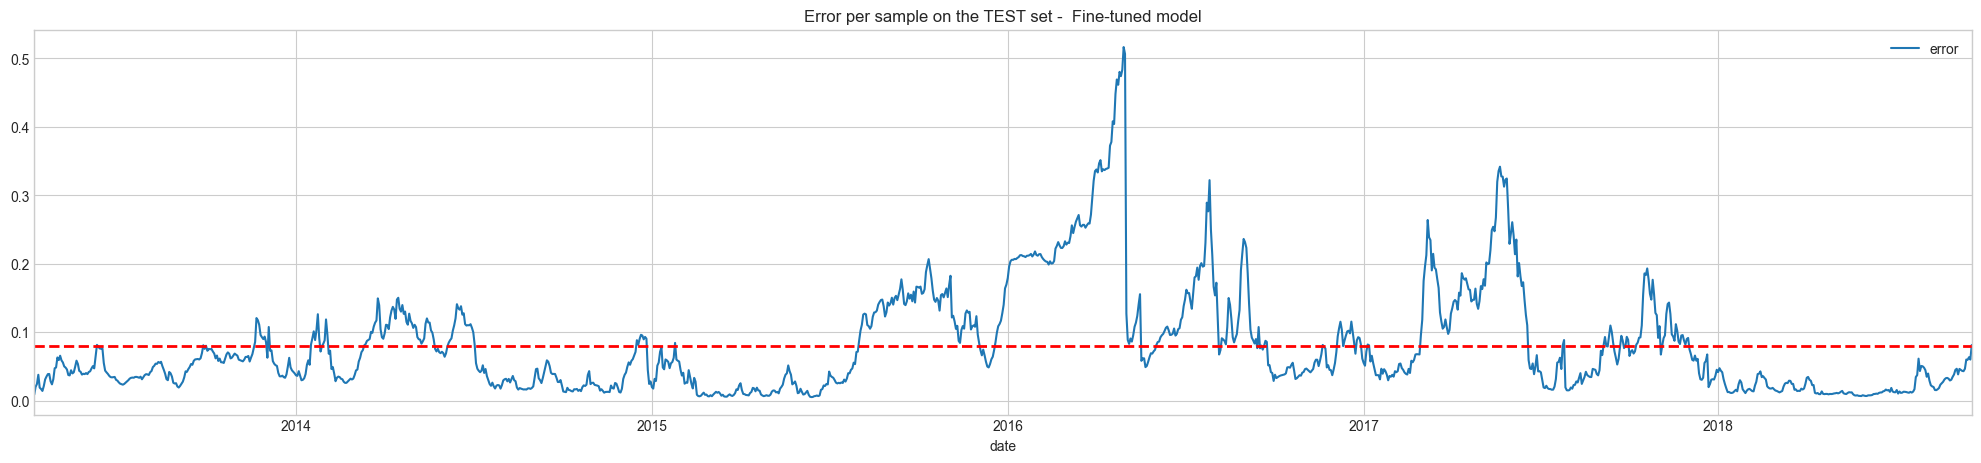

In [115]:
ft_test_df = construct_output_df(dset_test, finetuned_trainer)

ft_test_predictions = compare_forecast(ft_test_df, "date", "prediction", "actual", 30)
ft_test_predictions.plot(x="date", y=["pred", "actual"], figsize=(20,5), title="Finetuned model for exchange rate (TEST DATA)")

ft_test_df["error"] = ft_test_df.apply(lambda row: mean_squared_error([row["prediction"]], [row["actual"]]), axis=1)
ax = ft_test_df.plot(x="date", y=["error"], figsize=(25, 5), title="Error per sample on the TEST set -  Fine-tuned model")
ax.axhline(y=ft_test_df['error'].mean(), color="red", linestyle="--", linewidth=2, label=f"Avg Error = {ft_test_df['error'].mean():.3f}")

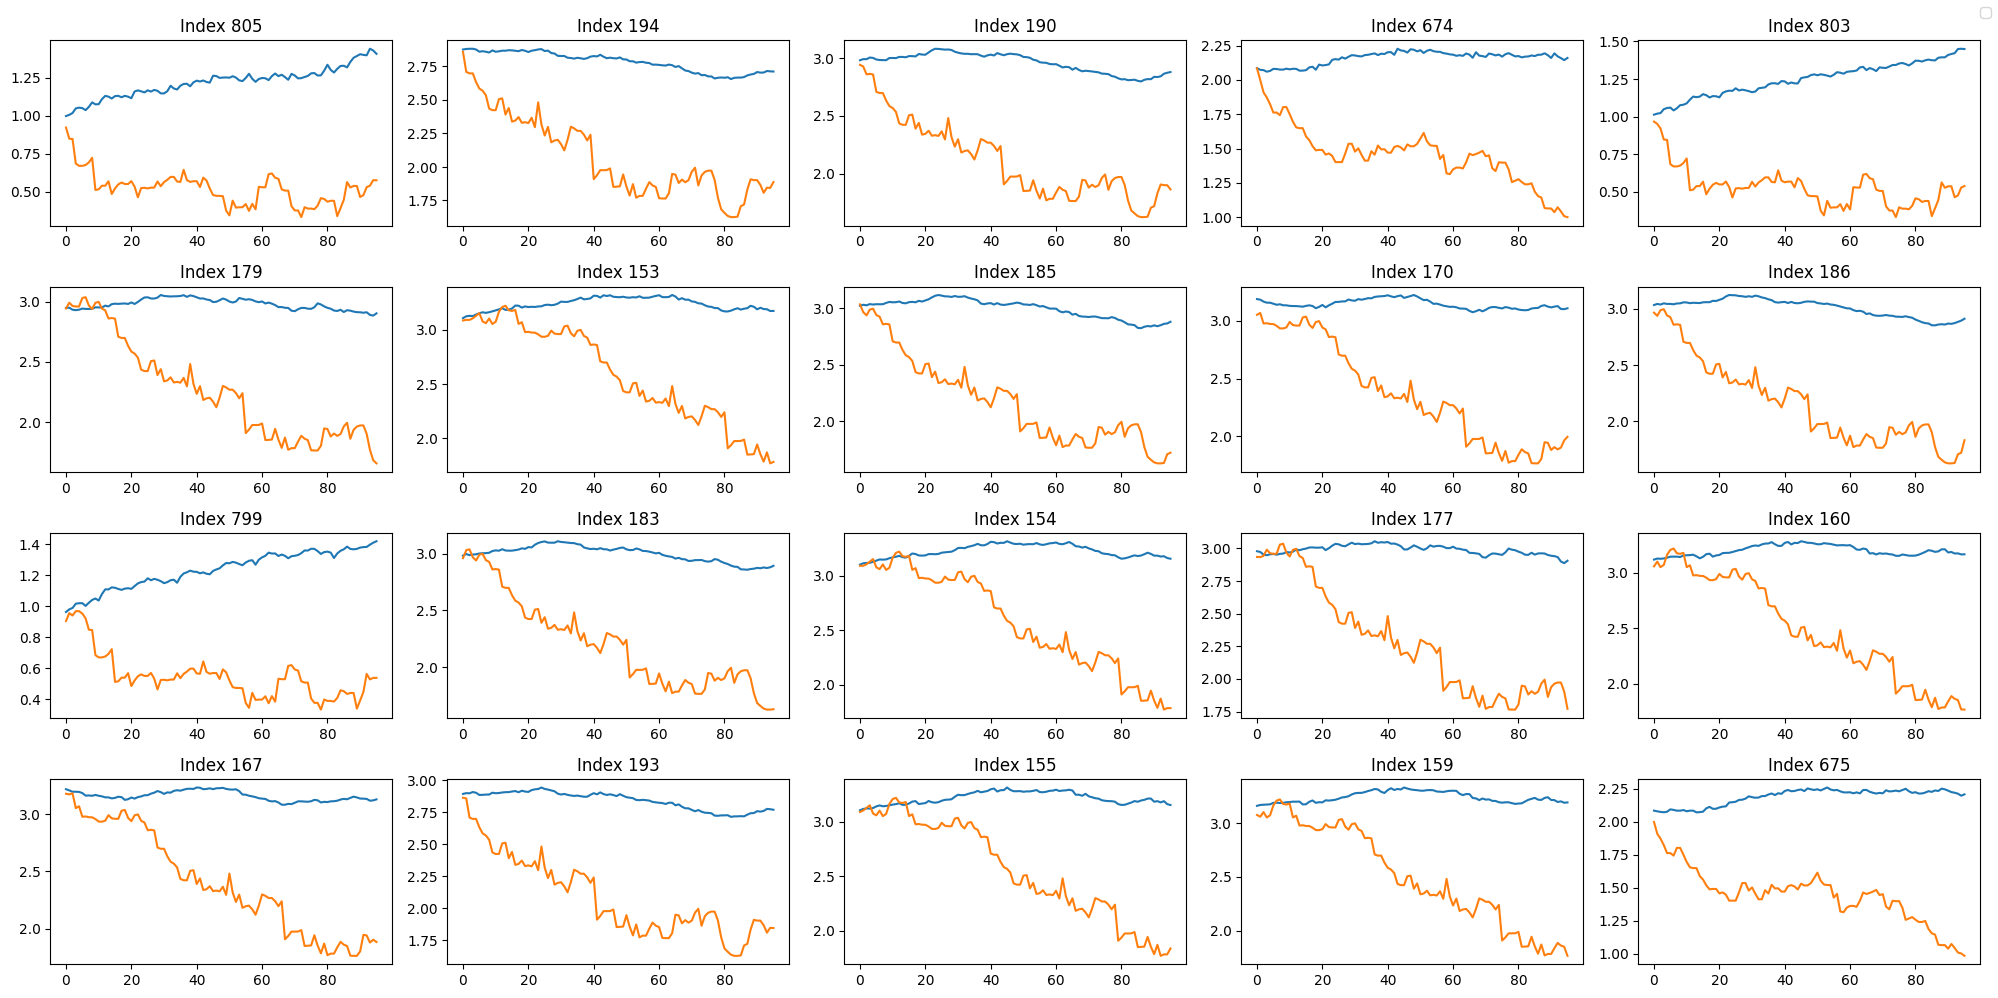

In [69]:
plot_high_error_samples(4, 5, ft_test_df, error_threshold=0.5)

In [116]:
columns = ["Exchange_rate", "Validation", "Test"]
rows = [
    ["ZS", 0.4505, 0.0790],
    ["FT", 0.4041, 0.0802], 
]
res_df = pd.DataFrame(rows, columns=columns)
print(res_df)


  Exchange_rate  Validation    Test
0            ZS      0.4505  0.0790
1            FT      0.4041  0.0802


In [118]:
high_error_val_samples = zs_val_df[zs_val_df["error"]>1.0]
len(high_error_val_samples)


51

In [128]:
context_array = np.array(high_error_val_samples["context"].tolist())
context_array.shape


(51, 512)

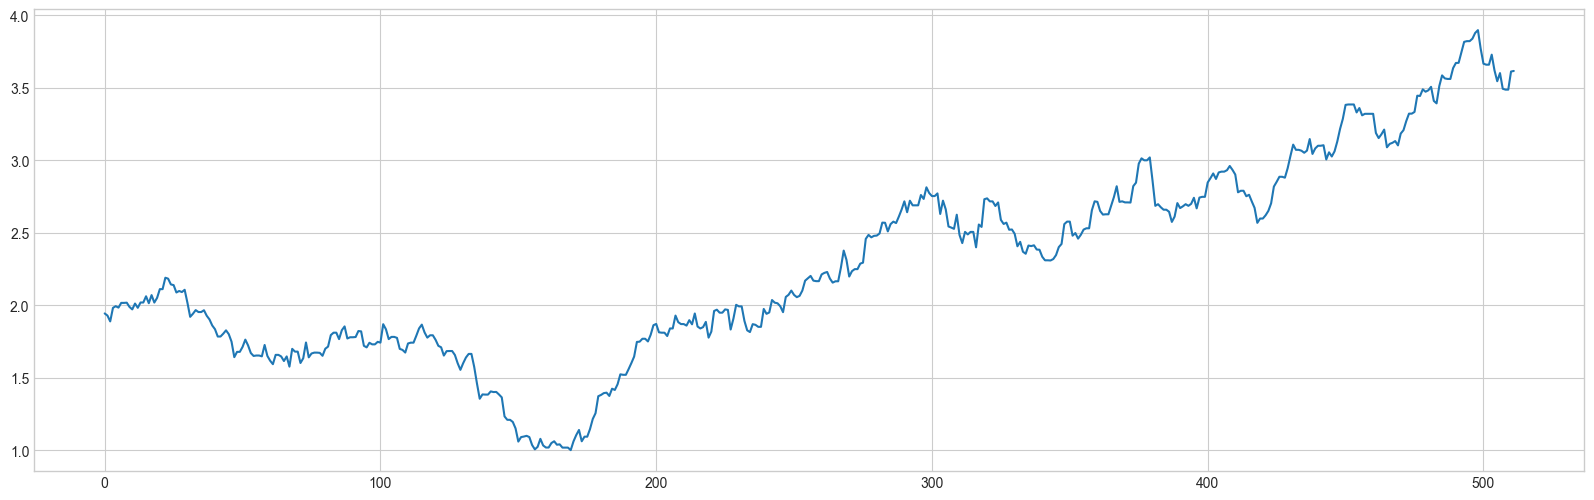

In [126]:
plt.figure(figsize=(20,6))
plt.plot(context_array[6])

In [129]:
import sys
sys.path.append("/Users/shivanitomar/Documents/Implementations/ps_pgsm_shapelets/incremental_code")
import utils

n, p = context_array.shape
r = 0.2
q = int(np.ceil(p * r))
k = 25
S, A, Offsets, F_obj = utils.USIDL_with_alpha_const(context_array, lambda_=0.1, K=k, q=q, c=100, epsilon=1e-5,
                                                    maxIter=2e3, maxInnerIter=5, random_seed=32)
shapelet_dict_v7 = {f'shapelet_{i}': S[i] for i in range(S.shape[0])}


setting random seed to 32 for dictionary initialization
Converged!


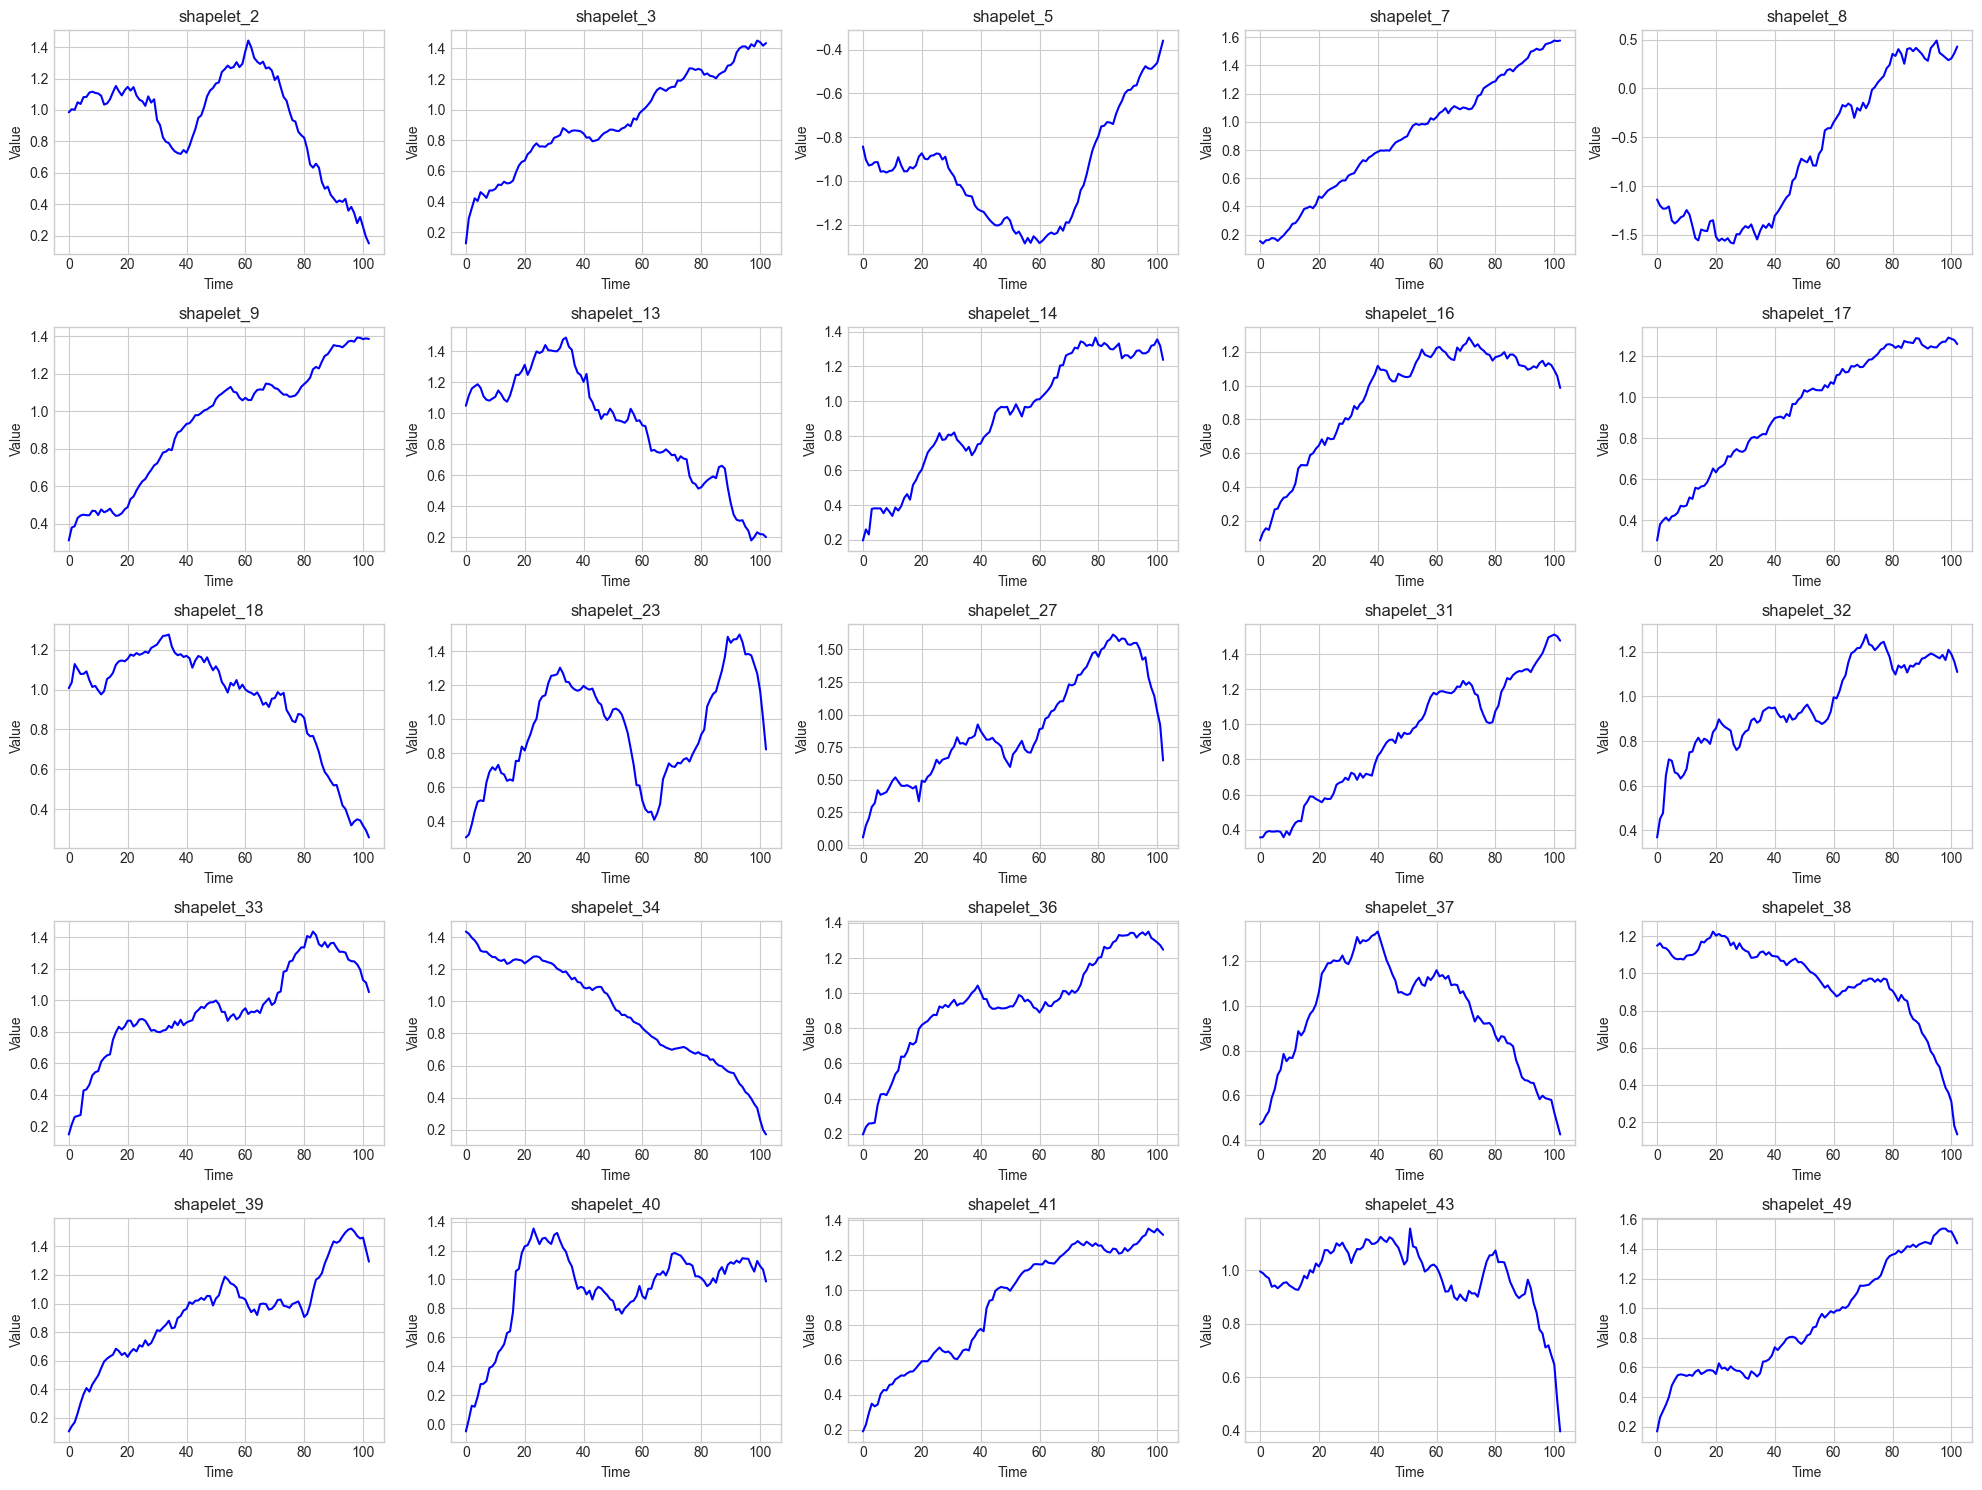

In [132]:
plot_shapelet_dict(select_shapelets_v7, 5)

In [133]:
#rank shapelets based on alpha coeff 
alpha_df = pd.DataFrame(A)
k=12

alpha_sum = alpha_df.sum(axis=0).to_frame().T
topk_shap_idx = alpha_sum.iloc[0].nlargest(k).index
df_top25 = alpha_sum[topk_shap_idx]

select_shapelets_v7 = {}
for key, value in shapelet_dict_v7.items():
    idx = int(key.split("_")[1])
    if idx in topk_shap_idx:
        select_shapelets_v7[key] = value
    

In [36]:
value_df = pd.DataFrame(
    high_error_val_samples['full_window'].tolist(),
    index=high_error_val_samples.index,
    columns=[f'timepoint_{i}' for i in range(len(high_error_val_samples['full_window'].iloc[0]))]
)

print(f"Shape: {value_df.shape}")
value_df

Shape: (149, 608)


timepoint_0  timepoint_1  timepoint_2  timepoint_3  timepoint_4  \
0      -0.400784    -0.217548    -0.290724    -0.497401    -0.427087   
1      -0.217548    -0.290724    -0.497401    -0.427087    -0.373744   
11     -0.652579    -0.669067    -0.695253    -1.002844    -0.845387   
12     -0.669067    -0.695253    -1.002844    -0.845387    -0.737927   
13     -0.695253    -1.002844    -0.845387    -0.737927    -0.734532   
..           ...          ...          ...          ...          ...   
507     0.943423     1.051214     1.217448     1.205596     1.237747   
509     1.217448     1.205596     1.237747     1.225837     1.332851   
510     1.205596     1.237747     1.225837     1.332851     1.354440   
511     1.237747     1.225837     1.332851     1.354440     1.380501   
512     1.225837     1.332851     1.354440     1.380501     1.389229   

     timepoint_5  timepoint_6  timepoint_7  timepoint_8  timepoint_9  ...  \
0      -0.373744    -0.450363    -0.649669    -0.770417    -0.794664  ...   
1      -0.450363    -0.649669    -0.770417    -0.794664    -0.751020  ...   
11     -0.737927    -0.734532    -0.725416    -0.629351    -0.691470  ...   
12     -0.734532    -0.725416    -0.629351    -0.691470    -0.759264  ...   
13     -0.725416    -0.629351    -0.691470    -0.759264    -0.766926  ...   
..           ...          ...          ...          ...          ...  ...   
507     1.225837     1.332851     1.354440     1.380501     1.389229  ...   
509     1.354440     1.380501     1.389229     1.423562     1.427238  ...   
510     1.380501     1.389229     1.423562     1.427238     1.449322  ...   
511     1.389229     1.423562     1.427238     1.449322     1.508037  ...   
512     1.423562     1.427238     1.449322     1.508037     1.505787  ...   

     timepoint_598  timepoint_599  timepoint_600  timepoint_601  \
0         1.846509       1.888785       1.946327       1.965394   
1         1.888785       1.946327       1.965394       1.967053   
11        2.084949       2.084949       2.178909       2.172818   
12        2.084949       2.178909       2.172818       2.235869   
13        2.178909       2.172818       2.235869       2.234986   
..             ...            ...            ...            ...   
507       3.016345       3.056109       3.023715       3.106522   
509       3.023715       3.106522       3.045567       2.939289   
510       3.106522       3.045567       2.939289       2.979985   
511       3.045567       2.939289       2.979985       2.989256   
512       2.939289       2.979985       2.989256       2.977104   

     timepoint_602  timepoint_603  timepoint_604  timepoint_605  \
0         1.967053       1.967053       2.051799       2.138155   
1         1.967053       2.051799       2.138155       2.102901   
11        2.235869       2.234986       2.276603       2.291752   
12        2.234986       2.276603       2.291752       2.282830   
13        2.276603       2.291752       2.282830       2.331177   
..             ...            ...            ...            ...   
507       3.045567       2.939289       2.979985       2.989256   
509       2.979985       2.989256       2.977104       2.977104   
510       2.989256       2.977104       2.977104       2.997306   
511       2.977104       2.977104       2.997306       2.947669   
512       2.977104       2.997306       2.947669       2.991216   

     timepoint_606  timepoint_607  
0         2.102901       2.046717  
1         2.046717       2.090933  
11        2.282830       2.331177  
12        2.331177       2.377304  
13        2.377304       2.395518  
..             ...            ...  
507       2.977104       2.977104  
509       2.997306       2.947669  
510       2.947669       2.991216  
511       2.991216       3.111808  
512       3.111808       3.049010  

[149 rows x 608 columns]

In [37]:
X = value_df.values[:, np.newaxis, :]
X.shape

(149, 1, 608)

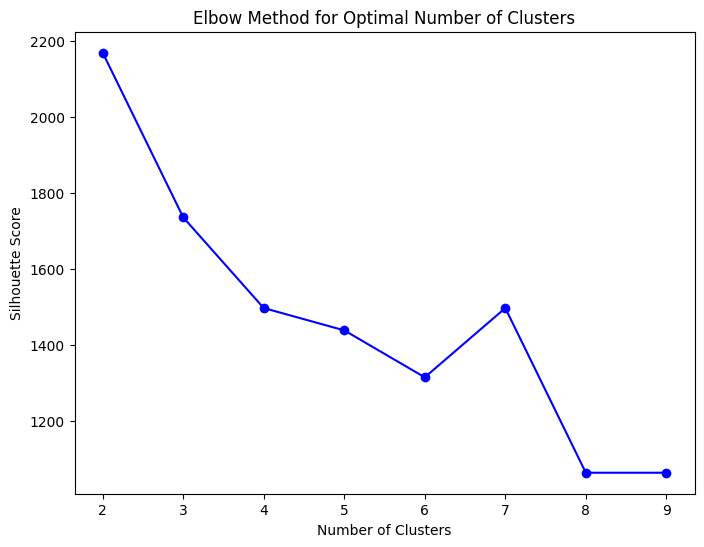

In [38]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import sktime
from sktime.clustering.k_means import TimeSeriesKMeans
from sklearn.metrics import silhouette_score

sum_of_squared_dist = []
K = range(2, 10)
# Fit models and calculate silhouette scores for each number of clusters
silhouette_scores = []
for n_clusters in K:
    
    km = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", verbose=False, max_iter=10, random_state=22)
    km = km.fit(X)
    sum_of_squared_dist.append(km.inertia_)
# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(K, sum_of_squared_dist, "bx--", marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [60]:
# For sktime, you might need to reshape this
model = TimeSeriesKMeans(
    n_clusters   = 3,
    metric       = "dtw",
    max_iter     = 10,
    random_state = 123456
)
labels = model.fit_predict(X)
print(f"\nCluster labels: {labels}")
print(f"Cluster sizes: {pd.Series(labels).value_counts().sort_index()}")


Cluster labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1]
Cluster sizes: 0    43
1    55
2    51
Name: count, dtype: int64


In [61]:
import torch

train_samples = []
timestamps = []

for i in range(len(dset_train)):
    sample = torch.cat((dset_train[i]['past_values'], dset_train[i]['future_values']), dim=0)
    train_samples.append(sample)

    timestamps.append(dset_train[i]['timestamp']) 

train_data = torch.stack(train_samples).squeeze(-1).numpy()
train_data_reshaped = np.expand_dims(train_data, axis=1)
columns = [f"timepoint_{i}" for i in range(train_data.shape[1])]
train_df = pd.DataFrame(train_data, columns=columns)
train_df["timestamp"] = timestamps
train_df.set_index("timestamp", inplace=True)

In [74]:
# use the clustering model to predict the clusters of the train samples
y_preds_test = model.predict(train_data_reshaped)
cluster_centers = model.cluster_centers_
print(len(cluster_centers))

3


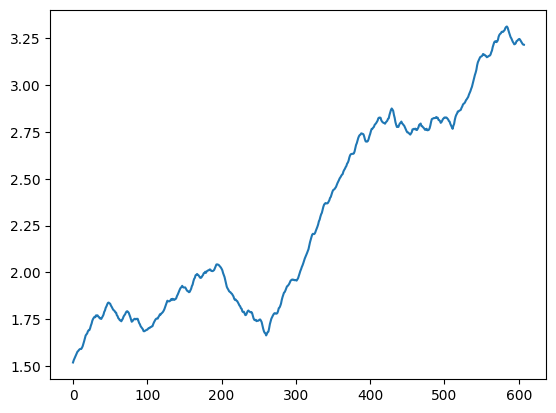

In [98]:
plt.plot(cluster_centers.reshape(3, 608)[1])

<Figure size 2000x1000 with 0 Axes>

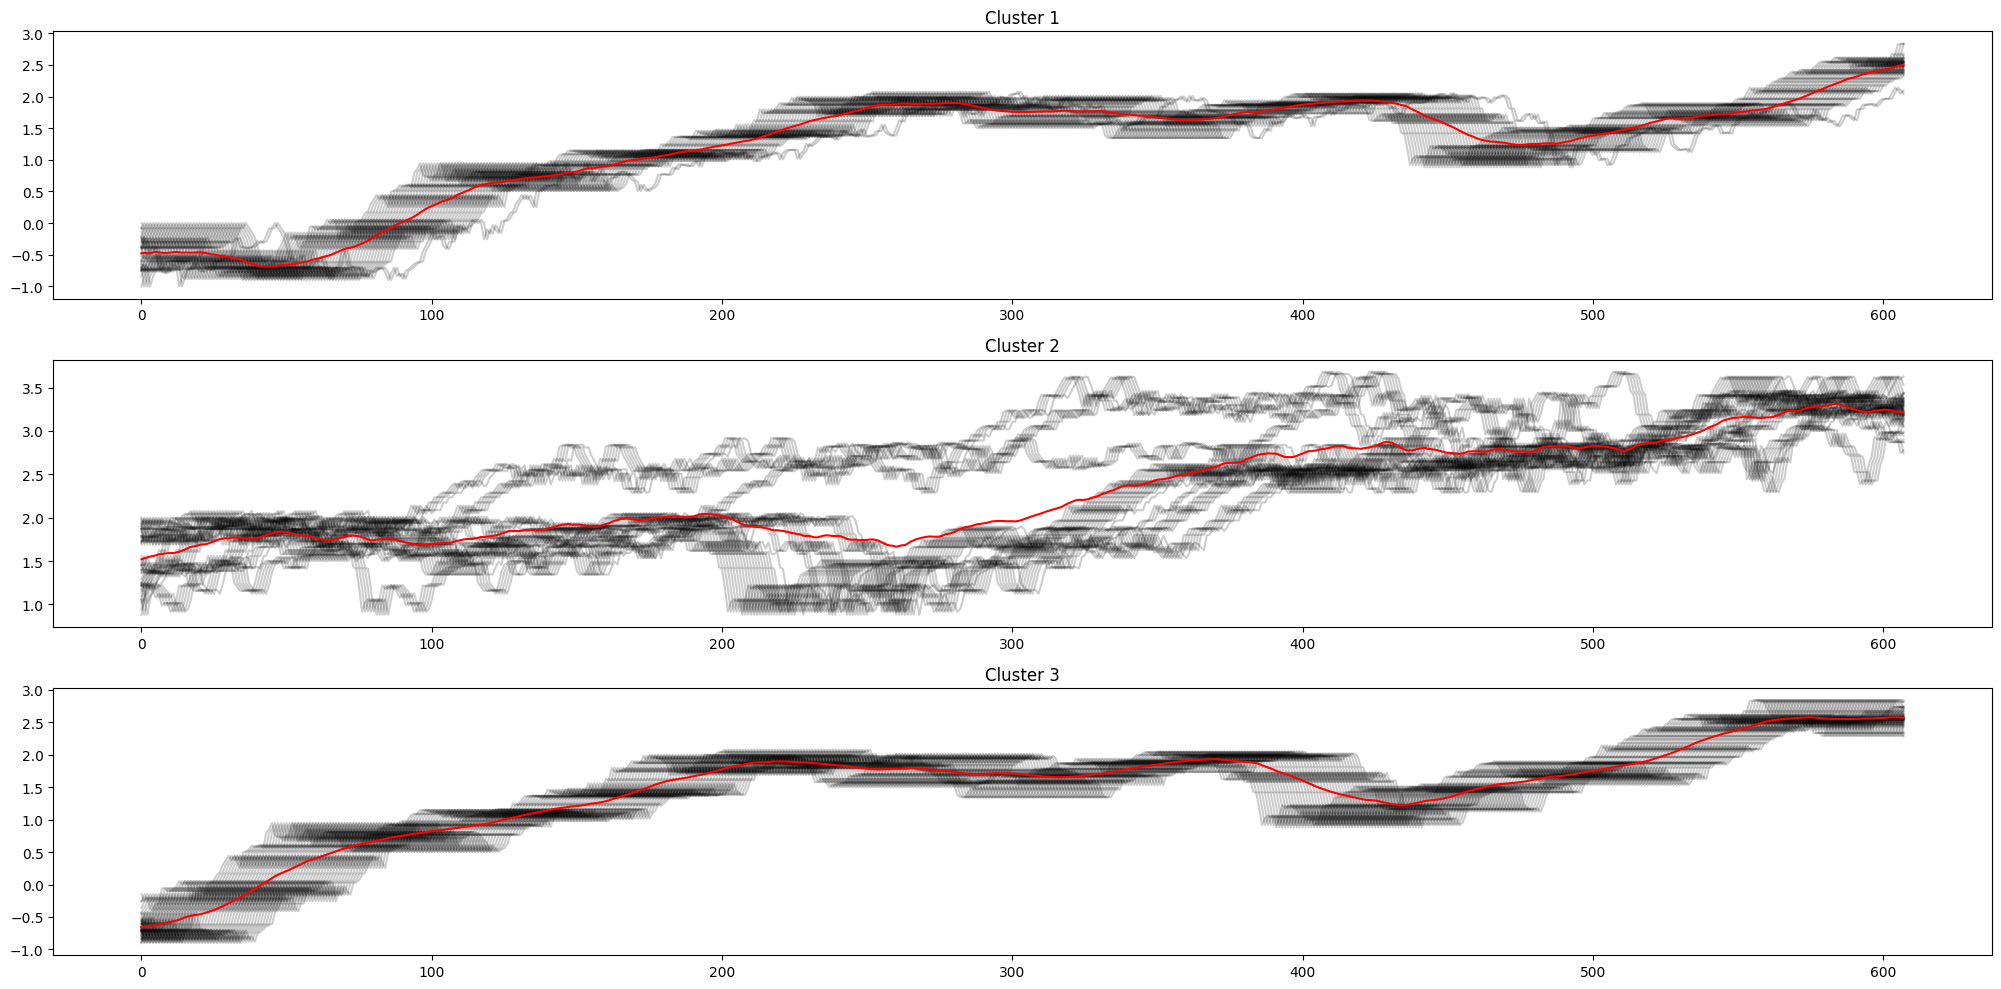

In [85]:
n_clusters = 3
plt.figure(figsize=(20, 10))
# Visualizing the clustering results
plt.figure(figsize=(20, 10))
for yi in range(n_clusters):
    plt.subplot(n_clusters, 1, 1 + yi)
    for xx in X[labels == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model.cluster_centers_[yi].ravel(), "r-")
    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.show()

In [63]:
pd.Series(y_preds_test).value_counts().sort_index()

0    4243
2     461
Name: count, dtype: int64

### Curate training samples similar to clusters identified from high error regions in Validation set

In [89]:
import torch

train_samples = []
timestamps = []

for i in range(len(dset_train)):
    sample = torch.cat((dset_train[i]['past_values'], dset_train[i]['future_values']), dim=0)
    train_samples.append(sample)

    timestamps.append(dset_train[i]['timestamp']) 

train_data = torch.stack(train_samples).squeeze(-1).numpy()
train_data_reshaped = np.expand_dims(train_data, axis=1)
columns = [f"timepoint_{i}" for i in range(train_data.shape[1])]
train_df = pd.DataFrame(train_data, columns=columns)
train_df["timestamp"] = timestamps
train_df.set_index("timestamp", inplace=True)

In [91]:
# use the clustering model to predict the clusters of the train samples
y_preds_test = model.predict(train_data_reshaped)
cluster_centers = model.cluster_centers_

In [96]:
pd.Series(y_preds_test).value_counts().sort_index()

0    4243
2     461
Name: count, dtype: int64

In [99]:
distances = []
for i, (sample, label) in enumerate(zip(train_df.values, y_preds_test)):
    
    center = cluster_centers[label]
    sample = train_df.iloc[i].values
    timestamp = train_df.index[i]
    from sktime.distances import dtw_distance
    dist = dtw_distance(sample, center)
     
    distances.append({
        'sample' : sample,
        'sample_idx': i,
        'cluster': label,
        'distance': dist,
        'timestamp': timestamp
    })

In [105]:
dist_df = pd.DataFrame(distances)

# select the timestamped observations closest to cluster centers in train set to curate the targeted training set
top_k_dict, top_k_list = get_top_k_timestamps_per_cluster(dist_df, k=200, ascending=True)
print(len(top_k_list))

timestamps_to_keep = set(top_k_list) 

keep_indices = [
    i for i in range(len(dset_train))
    if dset_train[i]['timestamp'] in timestamps_to_keep
]

from torch.utils.data import Subset

dset_train_filtered = Subset(dset_train, keep_indices)
len(dset_train_filtered)

400


400

In [185]:
# targeted training of model 

def targeted_finetune_eval(
    dataset_name,
    batch_size,
    learning_rate=None,
    context_length=512,
    forecast_length=96,
    fewshot_percent=100,
    freeze_backbone=True,
    num_epochs=10,
    save_dir=OUT_DIR,
    loss="mse",
    quantile=0.5,
):
    out_dir = os.path.join(save_dir, dataset_name)

    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)

    # change head dropout to 0.7 for ett datasets
    if "ett" in dataset_name:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            prediction_channel_indices=tsp.prediction_channel_indices,
            num_input_channels=tsp.num_input_channels,

            head_dropout=0.7,
            loss=loss,
            quantile=quantile,
        )
    else:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            # head_dropout=0.7,
            loss=loss,
            quantile=quantile,
        )

  
    print("after get_datasets ------", len(dset_train))

    if freeze_backbone:
        print(
            "Number of params before freezing backbone",
            count_parameters(finetune_forecast_model),
        )

        # Freeze the backbone of the model
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False

        # Count params
        print(
            "Number of params after freezing the backbone",
            count_parameters(finetune_forecast_model),
        )

    # Find optimal learning rate
    # Use with caution: Set it manually if the suggested learning rate is not suitable
    if learning_rate is None:
        learning_rate, finetune_forecast_model = optimal_lr_finder(
            finetune_forecast_model,
            dset_train,
            batch_size=batch_size,
        )
        print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(out_dir, "v2_output"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        eval_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=0,
        report_to="none",
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(out_dir, "logs"),  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
        seed=SEED,
        
    )

    # Create the early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=5,  # Number of epochs with no improvement after which to stop
        early_stopping_threshold=1e-5,  # Minimum improvement required to consider as improvement
    )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train_filtered) / (batch_size)),
    )
    print("length of training set is", len(dset_train_filtered))
    
    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train_filtered,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )
    finetune_forecast_trainer.remove_callback(INTEGRATION_TO_CALLBACK["codecarbon"])

    # Fine tune
    finetune_forecast_trainer.train()

    # Evaluation
    print("+" * 20, f"Test MSE after few-shot {fewshot_percent}% fine-tuning", "+" * 20)

    finetune_forecast_trainer.model.loss = "mse"  # fixing metric to mse for evaluation

    fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
    print(fewshot_output)
    print("+" * 60)

    # get predictions

    predictions_dict = finetune_forecast_trainer.predict(dset_test)
    print("prediction metrics on test set", predictions_dict[2])

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    # plot
    plot_predictions(
        model=finetune_forecast_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_fewshot",
        indices=[685, 118, 902],
        channel=0,
    )
    return predictions_dict

INFO:p-34235:t-8466403200:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 100% --------------------


INFO:p-34235:t-8466403200:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-34235:t-8466403200:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


after get_datasets ------ 4704
Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.001
length of training set is 400


  0%|          | 0/140 [00:00<?, ?it/s]

{'loss': 0.2454, 'grad_norm': 0.4340765178203583, 'learning_rate': 0.00010740658864614343, 'epoch': 1.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.2330799102783203, 'eval_runtime': 0.239, 'eval_samples_per_second': 2782.401, 'eval_steps_per_second': 46.025, 'epoch': 1.0}
{'loss': 0.2191, 'grad_norm': 0.9172179102897644, 'learning_rate': 0.0002906944871141138, 'epoch': 2.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.19165855646133423, 'eval_runtime': 0.2114, 'eval_samples_per_second': 3145.667, 'eval_steps_per_second': 52.034, 'epoch': 2.0}
{'loss': 0.2, 'grad_norm': 0.9213732481002808, 'learning_rate': 0.000538385312171217, 'epoch': 3.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.1768183410167694, 'eval_runtime': 0.1998, 'eval_samples_per_second': 3329.015, 'eval_steps_per_second': 55.066, 'epoch': 3.0}
{'loss': 0.1903, 'grad_norm': 1.2144274711608887, 'learning_rate': 0.0007809124240005861, 'epoch': 4.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.1636199802160263, 'eval_runtime': 0.2005, 'eval_samples_per_second': 3316.937, 'eval_steps_per_second': 54.867, 'epoch': 4.0}
{'loss': 0.158, 'grad_norm': 1.1226836442947388, 'learning_rate': 0.0009501594673413066, 'epoch': 5.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.1561661660671234, 'eval_runtime': 0.2012, 'eval_samples_per_second': 3305.118, 'eval_steps_per_second': 54.671, 'epoch': 5.0}
{'loss': 0.1411, 'grad_norm': 1.1548044681549072, 'learning_rate': 0.0009997431091279116, 'epoch': 6.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.19514362514019012, 'eval_runtime': 0.2163, 'eval_samples_per_second': 3073.807, 'eval_steps_per_second': 50.845, 'epoch': 6.0}
{'loss': 0.1248, 'grad_norm': 0.9800705909729004, 'learning_rate': 0.0009836474969297886, 'epoch': 7.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.17620764672756195, 'eval_runtime': 0.1948, 'eval_samples_per_second': 3414.177, 'eval_steps_per_second': 56.475, 'epoch': 7.0}
{'loss': 0.1117, 'grad_norm': 1.353306770324707, 'learning_rate': 0.0009432998799878872, 'epoch': 8.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.1903894692659378, 'eval_runtime': 0.2283, 'eval_samples_per_second': 2912.453, 'eval_steps_per_second': 48.176, 'epoch': 8.0}
{'loss': 0.0894, 'grad_norm': 0.8528871536254883, 'learning_rate': 0.0008807234562926504, 'epoch': 9.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.19158753752708435, 'eval_runtime': 0.2258, 'eval_samples_per_second': 2945.021, 'eval_steps_per_second': 48.715, 'epoch': 9.0}
{'loss': 0.0852, 'grad_norm': 0.8457428216934204, 'learning_rate': 0.000799056069024547, 'epoch': 10.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.191089928150177, 'eval_runtime': 0.1978, 'eval_samples_per_second': 3362.725, 'eval_steps_per_second': 55.624, 'epoch': 10.0}
{'train_runtime': 5.529, 'train_samples_per_second': 1446.908, 'train_steps_per_second': 25.321, 'train_loss': 0.1565132234777723, 'epoch': 10.0}
[TrackingCallback] Mean Epoch Time = 0.2755561351776123 seconds, Total Train Time = 5.5302770137786865
++++++++++++++++++++ Test MSE after few-shot 100% fine-tuning ++++++++++++++++++++


  0%|          | 0/23 [00:00<?, ?it/s]

{'eval_loss': 0.23239754140377045, 'eval_runtime': 0.4091, 'eval_samples_per_second': 3475.932, 'eval_steps_per_second': 56.221, 'epoch': 10.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


  0%|          | 0/23 [00:00<?, ?it/s]

prediction metrics on test set {'test_loss': 0.23239754140377045, 'test_runtime': 0.6737, 'test_samples_per_second': 2110.829, 'test_steps_per_second': 34.141}
(1422, 96, 1)
(1422, 1, 8, 192)


PredictionOutput(predictions=(array([[[2.9844534 ],
        [3.0163255 ],
        [3.0369573 ],
        ...,
        [3.240899  ],
        [3.2526512 ],
        [3.249139  ]],

       [[3.0083933 ],
        [3.032236  ],
        [3.0455751 ],
        ...,
        [3.242786  ],
        [3.2552173 ],
        [3.2522457 ]],

       [[3.090259  ],
        [3.0997825 ],
        [3.113516  ],
        ...,
        [3.2259488 ],
        [3.23832   ],
        [3.2433374 ]],

       ...,

       [[0.40686354],
        [0.41106614],
        [0.4051897 ],
        ...,
        [0.32591933],
        [0.31897256],
        [0.31627423]],

       [[0.4092844 ],
        [0.41224092],
        [0.39864525],
        ...,
        [0.3309171 ],
        [0.3248209 ],
        [0.32877582]],

       [[0.41406086],
        [0.41266406],
        [0.39667737],
        ...,
        [0.3442242 ],
        [0.342741  ],
        [0.34350973]]], dtype=float32), array([[[[ 0.00316218, -0.09378665,  0.27605197, ...,  0.07

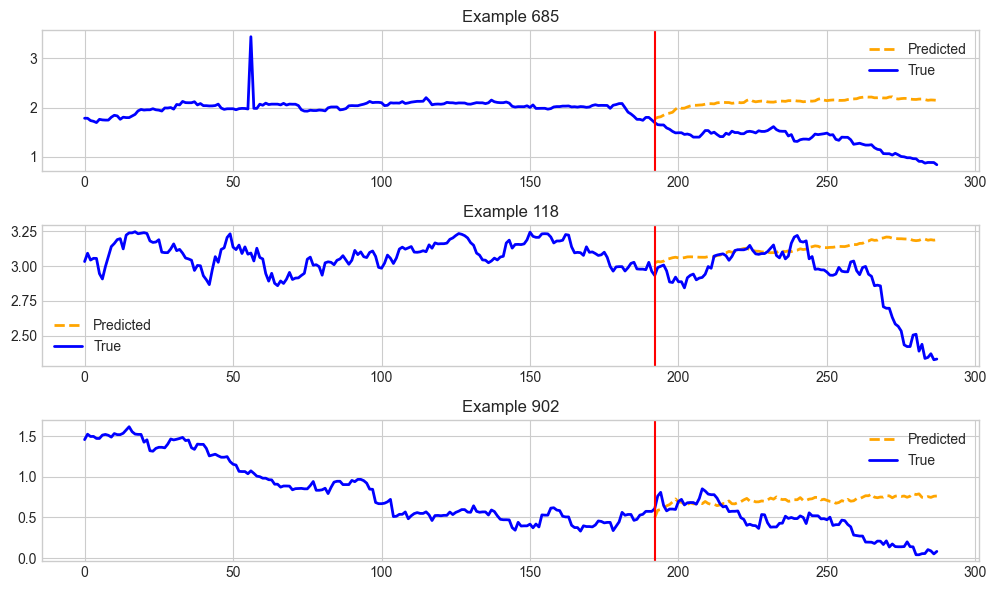

In [192]:
targeted_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=100,
    learning_rate=0.001,
    num_epochs=20,
)

In [189]:
targeted_tuned_model = TinyTimeMixerForPrediction.from_pretrained("/Users/shivanitomar/Documents/Implementations/granite-tsfm/notebooks/hfdemo/ttm_finetuned_models/exchange_rate/v2_output/checkpoint-105")
temp_dir = tempfile.mkdtemp()

targeted_finetuned_trainer = Trainer(
        model=targeted_tuned_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=64,
            seed=SEED,
            report_to="none",
        ),
    )

print("+" * 20, "Test MSE fine-tuned", "+" * 20)
targeted_output = targeted_finetuned_trainer.evaluate(dset_test)
print("targeted finetuned performance on test set", targeted_output)

++++++++++++++++++++ Test MSE fine-tuned ++++++++++++++++++++


  0%|          | 0/23 [00:00<?, ?it/s]

targeted finetuned performance on test set {'eval_loss': 0.2245417684316635, 'eval_model_preparation_time': 0.0011, 'eval_runtime': 0.4367, 'eval_samples_per_second': 3256.533, 'eval_steps_per_second': 52.672}


  0%|          | 0/23 [00:00<?, ?it/s]

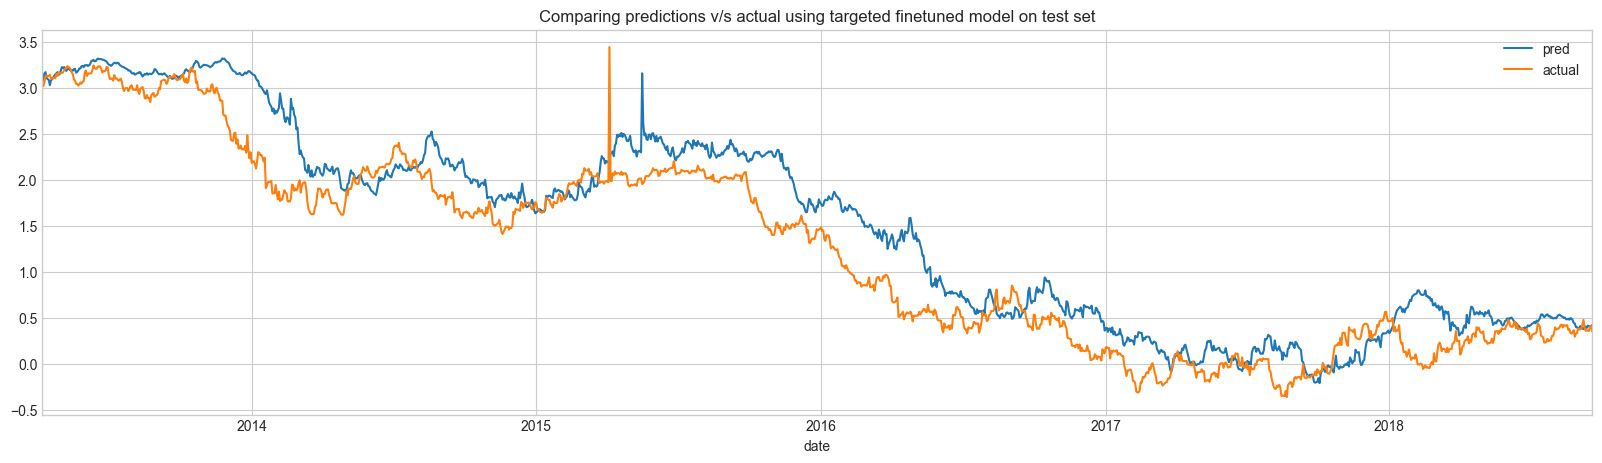

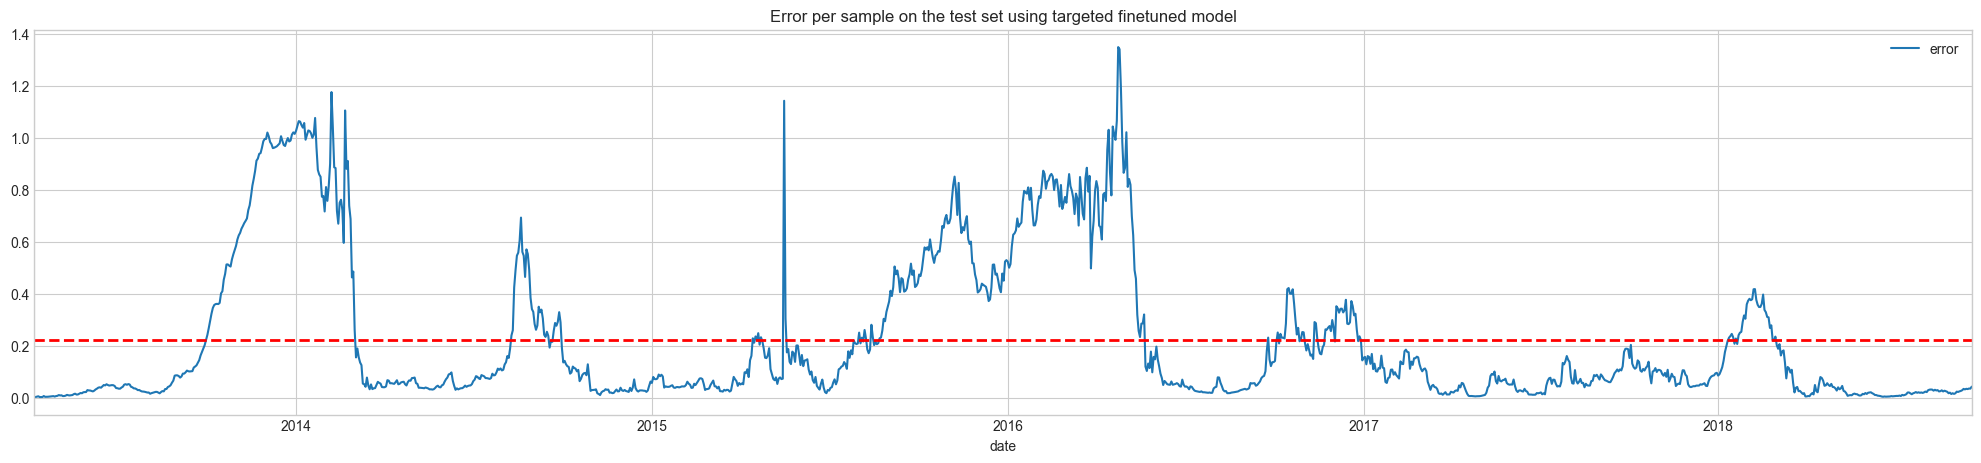

In [193]:
targeted_test_forecast_df = construct_output_df(dset_test, targeted_finetuned_trainer)
tar_test_predictions = compare_forecast(targeted_test_forecast_df, "date", "prediction", "actual", 30)
tar_test_predictions.plot(x="date", y=["pred", "actual"], figsize=(20,5), title="Comparing predictions v/s actual using targeted finetuned model on test set")

targeted_test_forecast_df["error"] = targeted_test_forecast_df.apply(lambda row: mean_squared_error([row["prediction"]], [row["actual"]]), axis=1)
ax_target = targeted_test_forecast_df.plot(x="date", y=["error"], figsize=(25, 5), title="Error per sample on the test set using targeted finetuned model")
ax_target.axhline(y=targeted_test_forecast_df['error'].mean(), color="red", linestyle="--", linewidth=2, label=f"Avg Error = {targeted_test_forecast_df['error'].mean():.3f}")

  0%|          | 0/23 [00:00<?, ?it/s]

<Axes: title={'center': 'Error per sample on the val set using finetuned and targeted models'}, xlabel='date'>

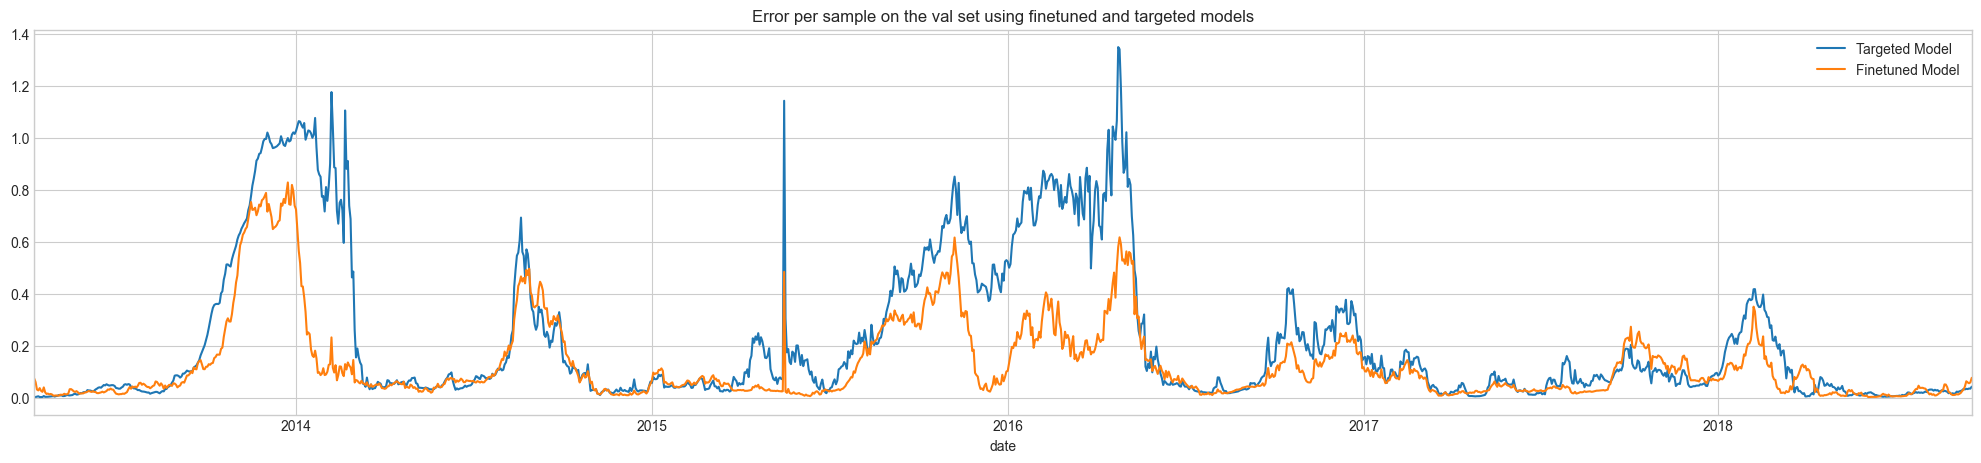

In [195]:
targeted_test_forecast_df = construct_output_df(dset_test, targeted_finetuned_trainer)
targeted_test_forecast_df["error"] = targeted_test_forecast_df.apply(lambda row: mean_squared_error([row["prediction"]], [row["actual"]]), axis=1)
ax5 = targeted_test_forecast_df.plot(
    x="date",
    y="error",
    figsize=(25, 5),
    label="Targeted Model",
    title="Error per sample on the val set using finetuned and targeted models"
)


ft_test_df.plot(
    x="date",
    y="error",
    ax=ax5,         
    label="Finetuned Model"
)

### Learning shapelets from high error regions of samples

In [135]:
drop_limit = int(0.2 * len(dset_test))
print("Allowed number of samples to discard predictions", drop_limit)

Allowed number of samples to discard predictions 284


In [136]:
len(select_shapelets_v7)

12

In [137]:
def z_norm(x):
    return (x - np.mean(x)) / np.std(x)

def shapelet_distance(segment, series):
    seg = z_norm(segment)
    series = z_norm(series)
    seg_len = len(seg)
    return min(np.linalg.norm(seg - series[i:i+seg_len]) for i in range(len(series)-seg_len+1))


test_distances_ed = np.zeros((len(dset_test),len(select_shapelets_v7)))

# save all the test distances with shapelets in an array
for i in range(len(dset_test)):
    for j, shapelet in enumerate(select_shapelets_v7.values()):
        series = np.array(dset_test[i]["past_values"].squeeze(1))
        dist = shapelet_distance(shapelet, series)
        test_distances_ed[i, j] = dist

In [139]:
import warnings

min_dists = test_distances_ed.min(axis=1)
sorted_idx = np.argsort(min_dists)
samples_to_drop = sorted_idx[:drop_limit]

# models_to_use = ["v"]

total_error = []

for i in range(len(dset_test)):
    if i in samples_to_drop:
        # print("Discarding the sample as due to high similarity with one of the shapelets")
        dis = 0
        total_error.append(dis)

    else:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            preds_dict = finetuned_trainer.predict([dset_test[i]])
            
            preds = preds_dict.predictions[0]
            preds = preds.squeeze(0)
            
            actual = np.array(dset_test[i]["future_values"])
            error = mean_squared_error(preds, actual)
            # print("error directly from index 2", preds_dict[2]["test_loss"])
            total_error.append(error)

# Error after discarding allowed unreliable predictions
print("Average error after discarding 10\% of the predictions due to close matches with shapelets: ", np.mean(total_error))
discard_df = pd.DataFrame(total_error, columns=["error"])
discard_df['date'] = zs_test_df["date"]



Average error after discarding 10\% of the predictions due to close matches with shapelets:  0.05680296251926251


In [140]:
print("Average error after discarding 10\% of the predictions due to close matches with shapelets: ", np.mean(total_error))

Average error after discarding 10\% of the predictions due to close matches with shapelets:  0.05680296251926251


<Axes: xlabel='date'>

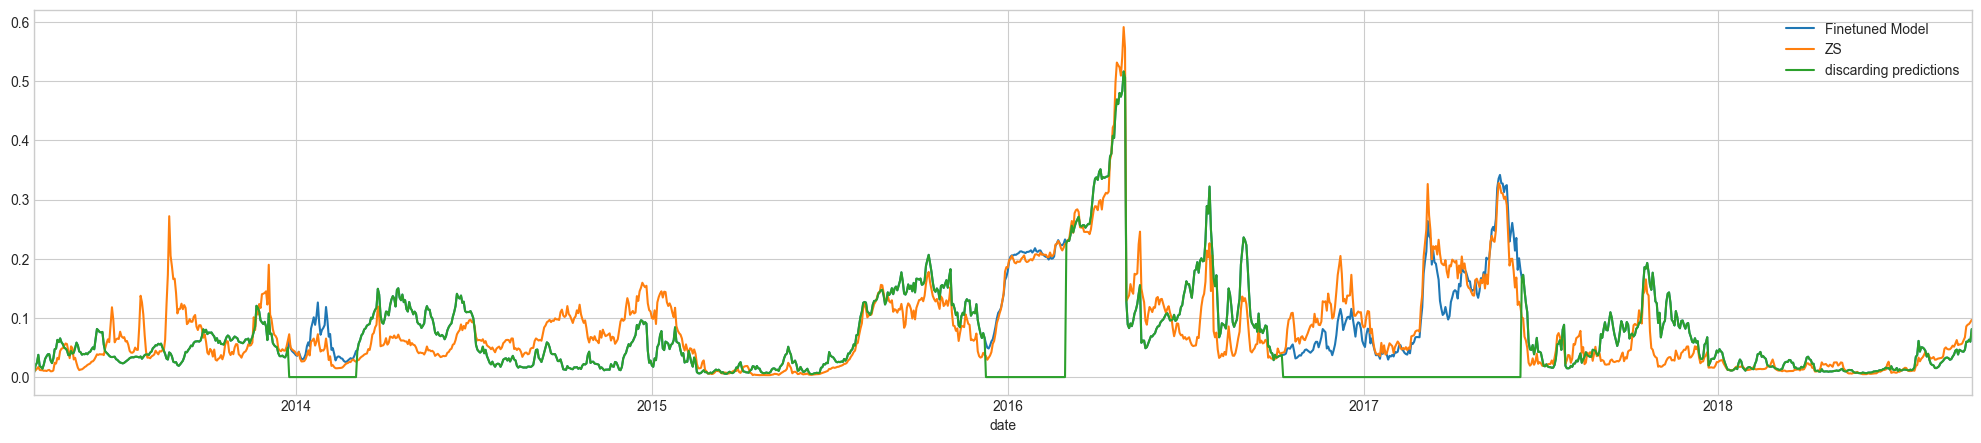

In [141]:
# ax8 = targeted_shap_df.plot(
#     x="date",
#     y="error",
#     figsize=(25, 5),
#     label="Targeted-shap Model",
#     title="Error per sample on the test set using finetuned and targeted(shap) models"
# )


ax8 =ft_test_df.plot(
    x="date",
    y="error",
    figsize=(25, 5),
    # ax=ax8,         
    label="Finetuned Model"
)

zs_test_df.plot(
    x="date",
    y="error",
    ax=ax8,
    label="ZS"
)

discard_df.plot(
    x="date",
    y="error",
    ax=ax8,
    label="discarding predictions"




)

### analyzing the data distribution before learning and matching shapelets

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

dataset_path = "/Users/shivanitomar/Documents/Implementations/SD_forger/FMforTS/data/monash_exchange_rate.csv"
columns_to_keep = ['currency_4', "timestamp"]

data = pd.read_csv(dataset_path)
data = data.drop(columns=[col for col in data.columns if col not in columns_to_keep])
data

timestamp  currency_4
0     1990-01-01    0.634196
1     1990-01-02    0.633513
2     1990-01-03    0.648508
3     1990-01-04    0.650618
4     1990-01-05    0.656254
...          ...         ...
7583  2019-01-24    0.969974
7584  2019-01-25    0.977297
7585  2019-01-28    0.984446
7586  2019-01-29    0.980344
7587  2019-01-30    0.980344

[7588 rows x 2 columns]

In [85]:
train_end = int(0.7*len(data))
val_end = train_end + int(0.1*len(data)) 


train_data = data[:train_end]
val_data = data[train_end : val_end]
test_data = data[val_end:]
print(len(train_data), len(val_data), len(test_data))


5311 758 1519


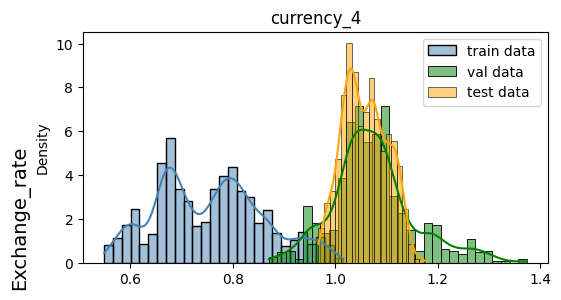

In [86]:
col = "currency_4"

plt.figure(figsize=(6, 3))
sns.histplot(train_data[col], color='steelblue', kde=True,
             stat='density', alpha=0.5, label='train data')
sns.histplot(val_data[col], color='green', kde=True,
             stat='density', alpha=0.5, label='val data')
sns.histplot(test_data[col], color='orange', kde=True,
             stat='density', alpha=0.5, label='test data')
plt.legend()
plt.xlabel('')
plt.ylabel('Density')
plt.title(col)
plt.suptitle("Exchange_rate", fontsize=14, x=0.02, y=0.5, rotation=90)
# plt.tight_layout()
plt.show()